In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import glob
import time 
from statsmodels.graphics.tsaplots import acf
from scipy.signal import periodogram
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime


import Lyapunov_funcs ### Functs from Lyapunov proof of concept notebook

In [2]:
pd.set_option('display.max_row', 1000)

# Get data

## 5 mins data

In [3]:
path = "/Users/calumthompson/Documents/Final year project/Data/S&P500 5mins/*"   #put folder data is in here

data_merge = []

for fname in glob.glob(path):
    x = pd.read_csv(fname)
    
    data_merge.append(x)

SandP_5mins = pd.concat(data_merge)

SandP_5mins.columns = SandP_5mins.columns.str.replace("<","").str.replace(">","")

SandP_5mins['TIMESTAMP'] = SandP_5mins['DATE'].astype(str) + SandP_5mins['TIME'].astype(str)
SandP_5mins['TIMESTAMP'] = pd.to_datetime(SandP_5mins['TIMESTAMP'] ,format='%Y%m%d%H%M%S')
SandP_5mins['DATE'] = pd.to_datetime(SandP_5mins['DATE'] ,format='%Y%m%d')
SandP_5mins = SandP_5mins.drop(axis =1, labels = ["TICKER","PER", "TIME"])

SandP_5mins = SandP_5mins[['DATE','TIMESTAMP','OPEN','HIGH','LOW','CLOSE','VOL']]
SandP_5mins = SandP_5mins.sort_values('TIMESTAMP')


/Users/calumthompson/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


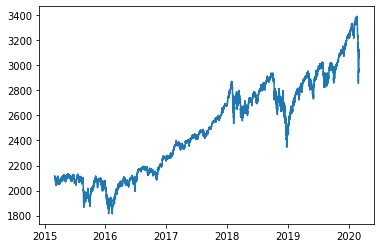

In [4]:
plt.plot(SandP_5mins['TIMESTAMP'], SandP_5mins['CLOSE'])
plt.show();

## 1 minutely data

In [5]:
path = "/Users/calumthompson/Documents/Final year project/Data/S&P500 1mins/*"   #put folder data is in here



data_merge = []

for fname in glob.glob(path):
    x = pd.read_csv(fname)
    
    data_merge.append(x)

SandP_1mins = pd.concat(data_merge)

SandP_1mins.columns = SandP_1mins.columns.str.replace("<","").str.replace(">","")

SandP_1mins['TIMESTAMP'] = SandP_1mins['DATE'].astype(str) + SandP_1mins['TIME'].astype(str)
SandP_1mins['TIMESTAMP'] = pd.to_datetime(SandP_1mins['TIMESTAMP'] ,format='%Y%m%d%H%M%S')
SandP_1mins['DATE'] = pd.to_datetime(SandP_1mins['DATE'] ,format='%Y%m%d')
SandP_1mins = SandP_1mins.drop(axis =1, labels = ["TICKER","PER", "TIME"])

SandP_1mins = SandP_1mins[['DATE','TIMESTAMP','OPEN','HIGH','LOW','CLOSE','VOL']]
SandP_1mins = SandP_1mins.sort_values('TIMESTAMP')


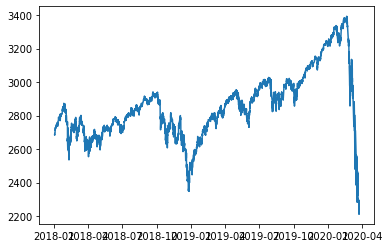

In [6]:
plt.plot(SandP_1mins['TIMESTAMP'], SandP_1mins['CLOSE'])
plt.show();

## Check sync

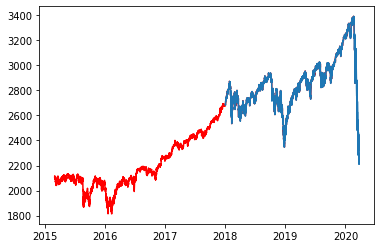

In [7]:
plt.plot(SandP_5mins['TIMESTAMP'], SandP_5mins['CLOSE'], c = 'r')
plt.plot(SandP_1mins['TIMESTAMP'], SandP_1mins['CLOSE'])
plt.show();

## Fractional change to close value

In [8]:
close_prices = pd.DataFrame(SandP_5mins.groupby('DATE')['OPEN'].last()).reset_index()
close_prices['Change %'] = (close_prices['OPEN'].diff()/ close_prices['OPEN']) *100

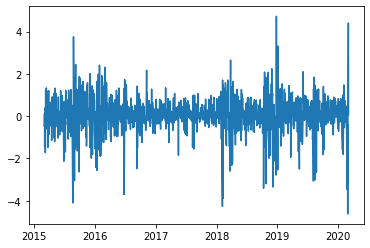

In [9]:
plt.plot(close_prices['DATE'], close_prices['Change %'])

# Functions

## Find lag $J$


In [10]:
def compute_lag(data, plot = False):

    autocorr = acf(data, fft = True, nlags = 500)

    if (plot):
        plt.plot(autocorr)
        plt.axhline(1 - 1/np.e, linestyle = "--", c = 'k', label = '1-1/e')
        plt.legend(loc = 'best')
        
    i = 0
        
    while (autocorr[i] > (1-1/np.e)):
        lag = autocorr[i]
        i += 1
        
    if (plot):
        plt.axvline(i)

    return i

## Embedding dimension $m$
- Time series is 1 dimensional therefore m > 2
- Do multiple tests to assess best embedding dimension
- Rich working on Cao's method


In [11]:
def compute_embedding_dimension():
    return 2

## Calculate mean period $\mu$

In [12]:
def compute_mean_period (timeseries):
    power_spectrum = periodogram(timeseries)[1]
    frequencies = periodogram(timeseries)[0]

    
    weights = power_spectrum / sum(power_spectrum)
    return 1/np.average(frequencies, weights = weights)

## Encode into phase space

In [13]:
def gen_phase_space_matrix(timeseries, J, m):
    
    timeseries = timeseries.to_list()
    
    matrix = pd.DataFrame(columns = np.arange(0,m))
        
    for i, val in enumerate(timeseries):
        
        x_i = []

        for it in range(0, m):
            
            try:
                i_plus_j = timeseries[i + J*it]
                x_i.append(i_plus_j)
            except:
                x_i.append(np.nan)
                
        
        matrix.loc[i] = x_i
    return matrix

## Find initial nearest neighbours

In [14]:
def euc_distance (p1, p2):
    
    try: 
        return distance.euclidean (p1,p2)
    except:
        return np.inf

In [15]:
def find_nearest_neighbour (dataframe, ref_index, mean_period, i_max = 25,print_error = False):
    
    start = datetime.datetime.now()
    
    dists = []
    ref_row = dataframe.iloc[ref_index, :].values

    min_dist = np.inf 
    min_index = np.nan

    for i in range(0,dataframe.shape[0] - i_max):

        test_row = dataframe.iloc[i, :].values

        if i != ref_index and abs(i-ref_index) > mean_period and euc_distance(ref_row, test_row) > 0:

            dist = euc_distance(ref_row, test_row)

            if dist  < min_dist:
                min_dist = dist
                min_index = i


    if min_dist == np.inf and print_error:
            print('Nearest neighbour not found for index ', ref_index)
            
    end = datetime.datetime.now()
        
    return min_index

## Compute divergence


In [16]:
def compute_divergence(dataframe, NN_pairs, i_max = 25): 
    
    dj_data = []
    
    for i in range (0,i_max): # calculate divergence through i_max steps
        
        dj_i = []
    
        for k in range (0,(dataframe.shape[0] - i_max)): # compute for all nearest neighbour pairs 
            
            if (np.nan not in NN_pairs[k]):
                NN_1 = NN_pairs[k][0]
                NN_2 = NN_pairs[k][1]

                p1 = dataframe.iloc[NN_1 + i, :]
                p2 = dataframe.iloc[NN_2 + i, :]

                if euc_distance(p1,p2) > 0: 
                    dj_i.append(euc_distance(p1,p2))
                
        
        dj_data.append([i,np.mean(np.log(dj_i))])
        

    return dj_data

## Find gradient - last years method

### Forward difference approximation

$$I'(t0) = (I1-I0) / (t1 - t0)$$

In [17]:
def forward_difference_approximation(x):
    
    diff_funct = []
    
    for i in range(0, len(x) - 1):
        i_prime = x[i+1] - x[i] #t1-t0 = 1
        diff_funct.append(i_prime)
    
    return diff_funct

### Linearity score

$$L = (N_{lin})^a + <ln(d')>^b$$

where $N_{lin}$ is the number of points within the concerned region, and $<ln(d')>$ is the mean gradient of the concerned region. The region with the highest was deemed to be the FLE region. The value of parameter b was chosen to be 2, so that linear regions with negative gradients could be identified.

a = 2.1

In [18]:
def score_linearity(start, end, x, x_prime, a = 2.1, b = 2):
    region = x[start + 1: end]
    region_grad = x_prime[start + 1: end]
    
    N = len(region)
    mean_grad = np.mean(region_grad)
        
    return (N**a) + (mean_grad**b)

In [19]:
def fit_linear_region(x, delta_t,plot_fit = False, plot_derivatives = False):
   
    #get derivative and 2nd derivative
    x_prime = forward_difference_approximation(x)
    x_dprime = forward_difference_approximation(x_prime)
    
    stdev = np.std(x_dprime)
        
    # identify regions where d'' > 1 std
    split_at = [0]
    
    for i, val in enumerate(x_dprime): 
        if np.abs(val) > stdev:
            split_at.append(i)
    split_at.append(len(x_dprime))
    
    # remove duplicates 
    split_at = list(set(split_at))    
    
    # assign linearity scores
    linearity_scores = []
    
    for i in range(0,len(split_at) - 1):
        start = split_at[i] + 1
        end = split_at[i+1] - 1 
        
        score = score_linearity(start,end,x, x_prime)
        linearity_scores.append(score)              
            
    # get linear fit for region with highest score
    fit_region_index = np.nanargmax(linearity_scores)

    start = split_at[fit_region_index] + 1 
    end = split_at[fit_region_index+1] - 1 
    
    fit_region_y = (x[start: end + 1]).values.reshape(-1,1)
    fit_region_x = (np.arange(start,end + 1) * delta_t).reshape(-1,1)
    
    regressor = LinearRegression() 
    regressor.fit(fit_region_x,fit_region_y)
    fit = regressor.predict(fit_region_x) 
    
    slope = regressor.coef_[0][0]
    error = metrics.mean_absolute_error(fit_region_y, fit)  
    r_squared = metrics.r2_score(fit_region_y,fit)
    
    
    
    ######################################################
            
    if plot_fit:
    # raw input
        
        plt.plot(np.arange(0, len(x)) * delta_t , x)
        plt.title('$\lambda_{1}$ = ' + '{:.4f}'.format(slope) + '+/-' '{:.4f}'.format(error))
        plt.xlabel('delta_t')
        plt.ylabel('$d_{j}}$')
        plt.plot(fit_region_x, fit, c = 'k')
       # plt.axhline(0, c = '0.25')
        
        for i in range(0,len(split_at)-1):
            start = split_at[i]+1
            end = split_at[i+1]-1
            plt.axvspan(start*delta_t,end*delta_t, color='red', alpha=0.35)
        plt.show();
        
    if plot_derivatives:    
    # derivative
        plt.plot(x_prime)
        plt.title('First derivative')
        plt.xlabel('i')
        plt.axhline(0, c = '0.25')
        plt.show();
        
    # second derivative
        print("Standard deviation = ",stdev)
        
        plt.plot(x_dprime)
        plt.title('Second derivative')
        plt.axhline(stdev, c = 'k', linestyle = ':')
        plt.axhline(-stdev, c = 'k', linestyle = ':')
        plt.axhline(0, c = '0.25')
        plt.xlabel('i')
        
        out_of_bounds = [x_dprime[i] for i in split_at[0:len(split_at) -1]]
        plt.scatter(split_at[0:len(split_at) -1], out_of_bounds, c = 'r', label = 'points out of bounds')
        plt.legend()
        plt.show();
        
        
    return slope, error 
    

## Apply to data series

Lyapunov exponent $\lambda _{1}$ can be found from the following equation

$$ ln(d_{j}(i)) = \lambda _{1}i\Delta t + ln(d_{j}(0)) $$

In [20]:
def calc_daily_lyapunov_exponent(dataframe, date, column = "OPEN", i_max = 25, plot_fit = False, plot_derivatives = False, delta_t_unit = 'days', time = False):
    
    timings = []
    timings.append(['start',datetime.datetime.now()])
        
    regressor = LinearRegression()  
    
    time_series = dataframe.loc[dataframe["DATE"] == date][column]
    
    
    ### compute constants    
    timings.append(['compute consts',datetime.datetime.now()])
        
    J = compute_lag(time_series, plot = False)
    m = compute_embedding_dimension()
    mu = compute_mean_period(time_series)
    
    if delta_t_unit == 'mins':
        delta_t = 1
    elif delta_t_unit == 'hours':
        delta_t = 1/(60)
    elif delta_t_unit == 'days':
        delta_t = 1/(24*60)
    
    ### generate matrix
    timings.append(['gen matrix',datetime.datetime.now()])
    matrix = gen_phase_space_matrix(time_series, J, m)
    matrix = matrix.dropna() ## drop rows that are missing a phase space co-ord (due to lag taking past end of list)
        
    ### find nearest neighbour pairs
    NN_pairs = []

    timings.append(['compute nearest neighbours',datetime.datetime.now()])
        
        
    for i in range(0,matrix.shape[0]):
        NN = find_nearest_neighbour(matrix, ref_index= i, mean_period = mu, i_max = i_max)
        NN_pairs.append([i,NN])

        
    ### calculative divergence 

    timings.append(['calc divergence',datetime.datetime.now()])
    lyapunov_data = pd.DataFrame(compute_divergence(matrix, NN_pairs, i_max = i_max), columns = ['i','log(dj)'])
        
    #return lyapunov_data 
        
    ### fit to get lyapunov
    if time:
        timings.append(['fit',datetime.datetime.now()])
        
    lyapunov_exponent, error =  fit_linear_region(lyapunov_data['log(dj)'],delta_t, plot_fit, plot_derivatives)

    timings.append(['end', datetime.datetime.now()])
    
    timings = pd.DataFrame(timings,columns = ['task', 'start time'])
    timings['duration (s)'] = np.abs(timings['start time'].diff(periods = -1).dt.total_seconds())
    total_time = timings['duration (s)'].sum()
    
    if time:
        print(timings)
        print("Total time to find lyapunov exponent = ",total_time)
        return lyapunov_exponent, error, timings, total_time
    else:
        return lyapunov_exponent, error, total_time


## Apply to multiple days


In [74]:
def calculate_lyapunov_exponents(matrix, start_date, end_date, plot_fit = False, plot_derivatives = False, i_max = 25, delta_t_unit = 'days'):
   
    # Open file for records
    filename = str(start) + " to " + str(end) + ".csv"
    f = open(filename, 'w')
    f.write('DATE,lyapunov_exponent,error\n')
    
    # Load data to be computed
    sample = matrix.loc[(matrix['DATE'] >= start_date) & (matrix['DATE'] <= end_date)]

    dates = sample['DATE'].unique()
    
    results = []
    run_time = []
    start_time = datetime.datetime.now()
    cycle_count = 0
    
    # Print some stuff before beginning
    print("computing for ", len(dates), 'days')
    print("Start at ", start_time )
    print("")
    
    
    # Iterate through dates
    for date in dates:
        
        print_date = pd.to_datetime(date)
        print("")
        print(cycle_count + 1,") Computing ", print_date.strftime("%a %d %b %Y"), "... ", end ="")
        
        try:
            lyapunov_exponent, error, total_time = calc_daily_lyapunov_exponent(sample,date, i_max = i_max, plot_fit = plot_fit, plot_derivatives = plot_derivatives, delta_t_unit = delta_t_unit)
        
            results.append([date,lyapunov_exponent, error])
            run_time.append(total_time)

            print("computed in ", total_time, 's')

            expected_time = (len(dates) - cycle_count - 1) * np.mean(run_time)
            print("Expected time remaining = ", expected_time, "s")
            
            f.write(str(date)+ ',' + str(lyapunov_exponent) + ',' + str(error) + '\n')
            
        except:
            print("Error with record = ", print_date.strftime("%a %d %b %Y"))
            
        cycle_count+= 1
    
    end_time = datetime.datetime.now()

    print("computation time = ", (end_time-start_time).total_seconds())

    results = pd.DataFrame(results, columns = ['DATE','lyapunov_exponent', 'error'])
    
    f.close()
    
    return results
    

# Apply to data

# Test for a day

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


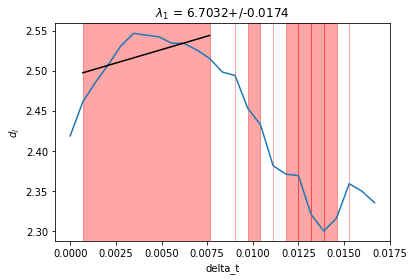

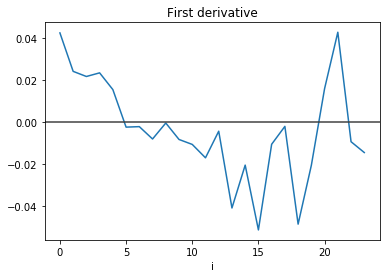

Standard deviation =  0.023927574089360793


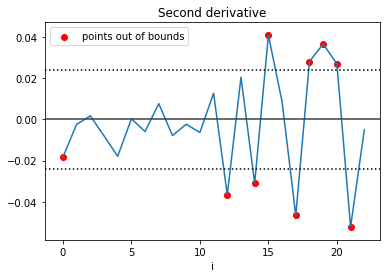

(6.703204118975206, 0.017387454979955187, 16.304208000000003)

In [84]:
calc_daily_lyapunov_exponent(SandP_1mins, '2019-07-01', plot_fit =True, plot_derivatives=True , i_max = 25, time = False)


# Apply to multiple days

In [38]:
start = '2019-01-02'
end = '2020-01-02'

computing for  253 days
Start at  2020-03-26 17:29:59.602984


1 ) Computing  Wed 02 Jan 2019 ... 

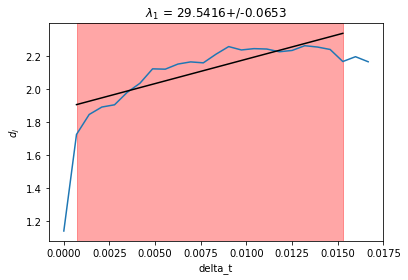

computed in  19.237392 s
Expected time remaining =  4847.822784 s

2 ) Computing  Thu 03 Jan 2019 ... 

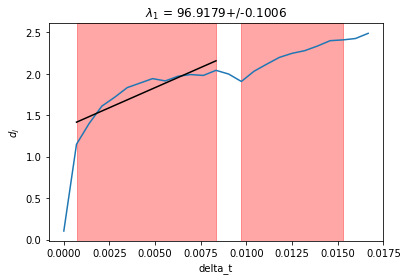

computed in  22.133238 s
Expected time remaining =  5192.014064999999 s

3 ) Computing  Fri 04 Jan 2019 ... 

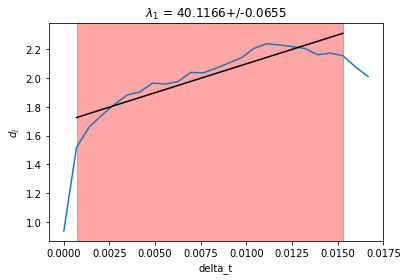

computed in  21.400156 s
Expected time remaining =  5230.898833333334 s

4 ) Computing  Mon 07 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


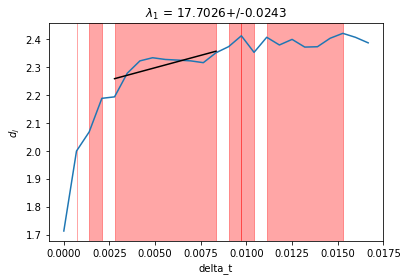

computed in  17.579041 s
Expected time remaining =  5001.77673075 s

5 ) Computing  Tue 08 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


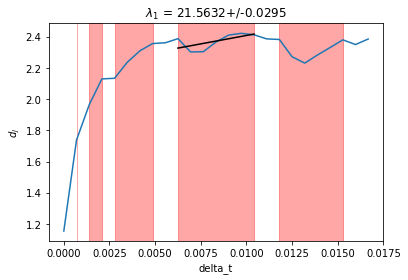

computed in  18.630402000000004 s
Expected time remaining =  4909.4193584 s

6 ) Computing  Wed 09 Jan 2019 ... 

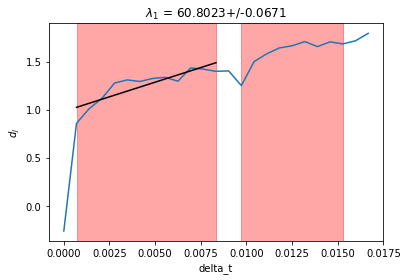

computed in  20.791738000000002 s
Expected time remaining =  4930.612641500001 s

7 ) Computing  Thu 10 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


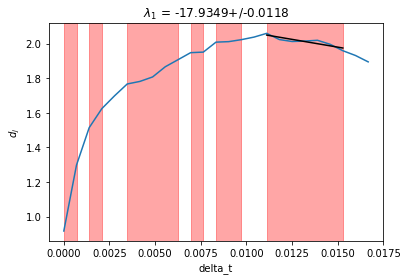

computed in  21.625725 s
Expected time remaining =  4969.118890285715 s

8 ) Computing  Fri 11 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


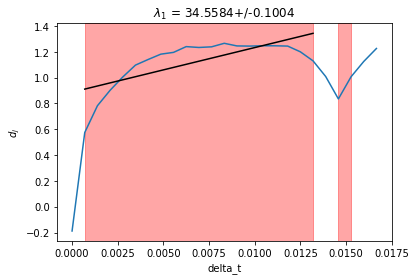

computed in  22.09146 s
Expected time remaining =  5006.855280000001 s

9 ) Computing  Mon 14 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


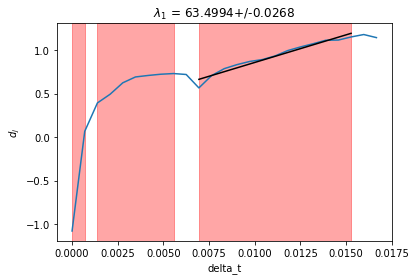

computed in  22.617515000000004 s
Expected time remaining =  5045.558527555556 s

10 ) Computing  Tue 15 Jan 2019 ... 

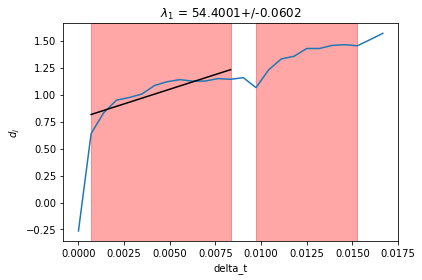

computed in  21.616677000000003 s
Expected time remaining =  5047.677259200001 s

11 ) Computing  Wed 16 Jan 2019 ... 

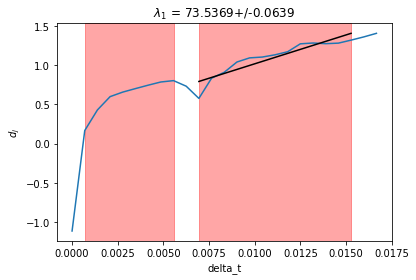

computed in  21.483545000000003 s
Expected time remaining =  5042.551558 s

12 ) Computing  Thu 17 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


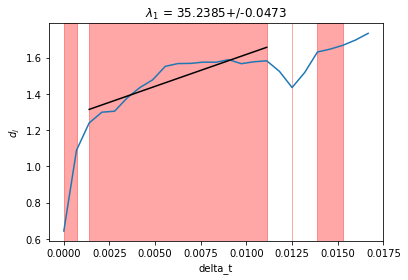

computed in  20.427198999999998 s
Expected time remaining =  5013.484600666667 s

13 ) Computing  Fri 18 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


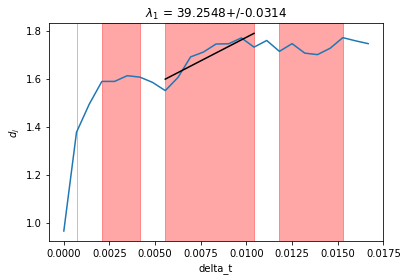

computed in  17.648312 s
Expected time remaining =  4934.444307692307 s

14 ) Computing  Tue 22 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


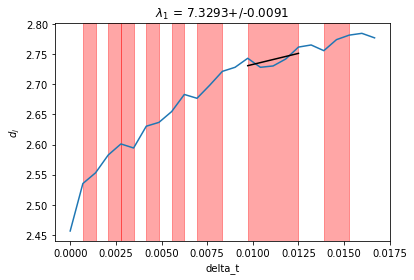

computed in  16.024432 s
Expected time remaining =  4836.452346285714 s

15 ) Computing  Wed 23 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


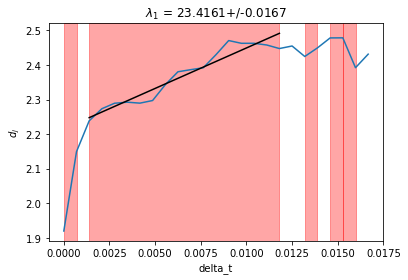

computed in  16.699942 s
Expected time remaining =  4760.1074808 s

16 ) Computing  Thu 24 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


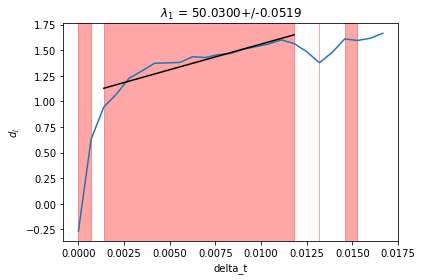

computed in  19.761523 s
Expected time remaining =  4736.5678993125 s

17 ) Computing  Fri 25 Jan 2019 ... 

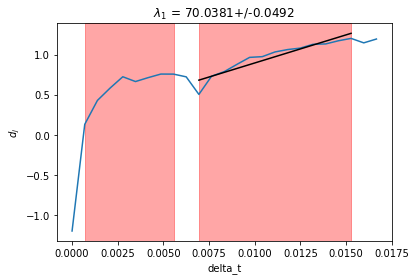

computed in  22.802958 s
Expected time remaining =  4755.695069411765 s

18 ) Computing  Mon 28 Jan 2019 ... 

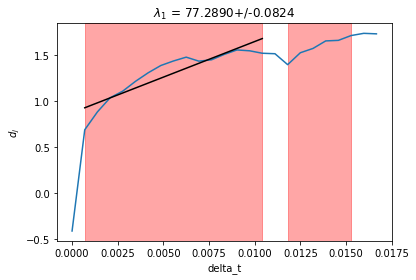

computed in  21.375686 s
Expected time remaining =  4751.5295075 s

19 ) Computing  Tue 29 Jan 2019 ... 

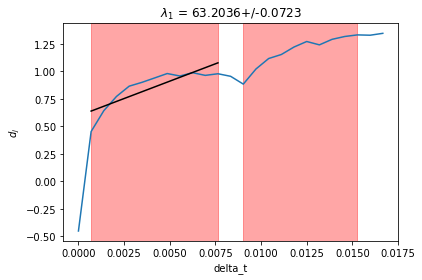

computed in  22.199283 s
Expected time remaining =  4755.695600842106 s

20 ) Computing  Wed 30 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


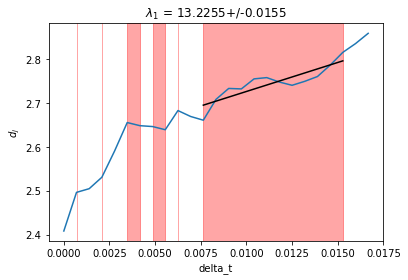

computed in  16.559276 s
Expected time remaining =  4691.519075 s

21 ) Computing  Thu 31 Jan 2019 ... 

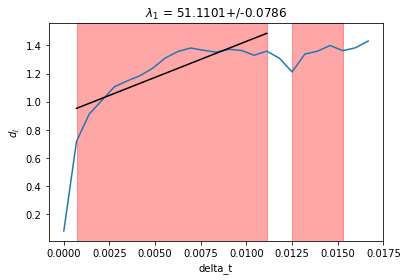

computed in  20.52464 s
Expected time remaining =  4675.685356190476 s

22 ) Computing  Fri 01 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


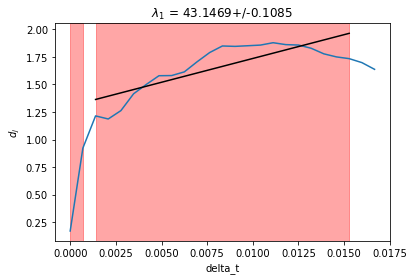

computed in  19.345007000000003 s
Expected time remaining =  4647.0390435 s

23 ) Computing  Mon 04 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


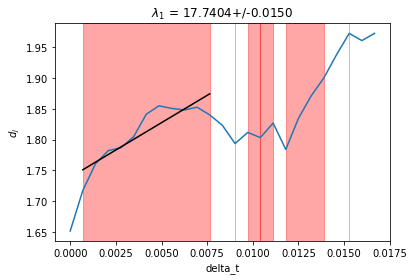

computed in  16.768418 s
Expected time remaining =  4593.43565 s

24 ) Computing  Tue 05 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


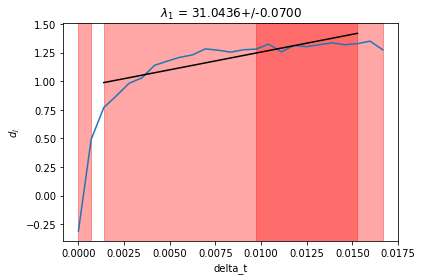

computed in  19.004106 s
Expected time remaining =  4564.234027458333 s

25 ) Computing  Wed 06 Feb 2019 ... 

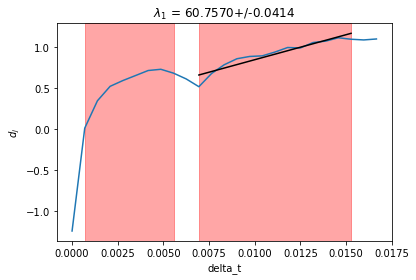

computed in  21.542862 s
Expected time remaining =  4559.001660960001 s

26 ) Computing  Thu 07 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


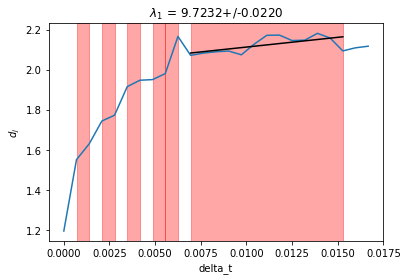

computed in  17.599745000000002 s
Expected time remaining =  4518.088196384616 s

27 ) Computing  Fri 08 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


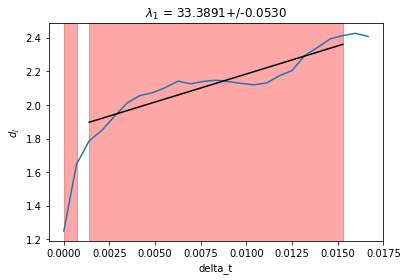

computed in  16.657753000000003 s
Expected time remaining =  4471.0168520740735 s

28 ) Computing  Mon 11 Feb 2019 ... 

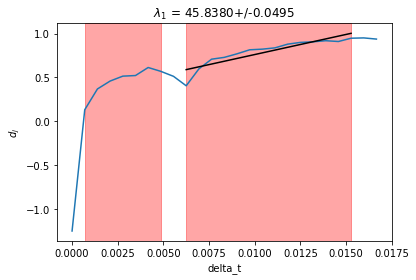

computed in  21.721252 s
Expected time remaining =  4466.806738392857 s

29 ) Computing  Tue 12 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


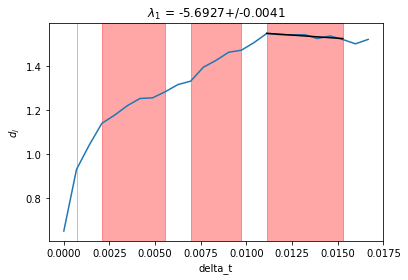

computed in  18.090003 s
Expected time remaining =  4433.340691862069 s

30 ) Computing  Wed 13 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


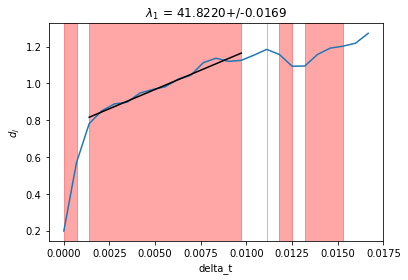

computed in  19.401813 s
Expected time remaining =  4410.6508359 s

31 ) Computing  Thu 14 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


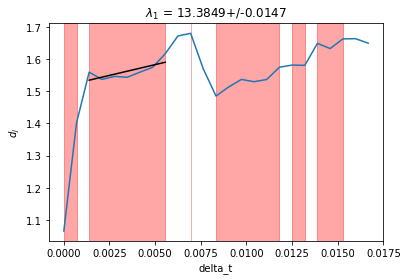

computed in  17.674745 s
Expected time remaining =  4375.805076387097 s

32 ) Computing  Fri 15 Feb 2019 ... 

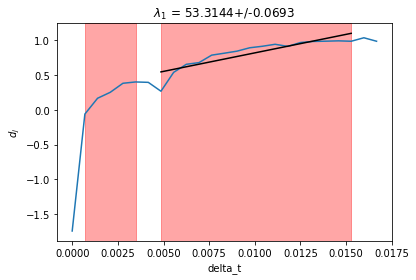

computed in  22.800943000000004 s
Expected time remaining =  4377.43531021875 s

33 ) Computing  Tue 19 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


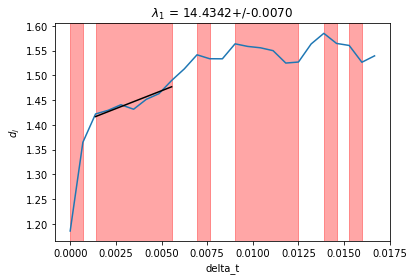

computed in  17.795538 s
Expected time remaining =  4344.215499999999 s

34 ) Computing  Wed 20 Feb 2019 ... 

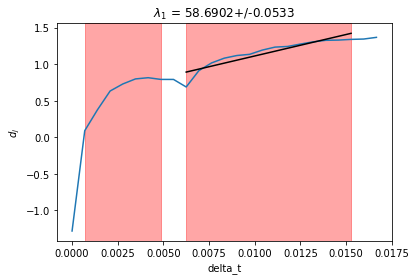

computed in  22.045607 s
Expected time remaining =  4339.278444352941 s

35 ) Computing  Thu 21 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


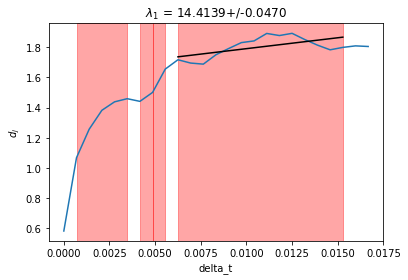

computed in  18.3593 s
Expected time remaining =  4310.403330742857 s

36 ) Computing  Fri 22 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


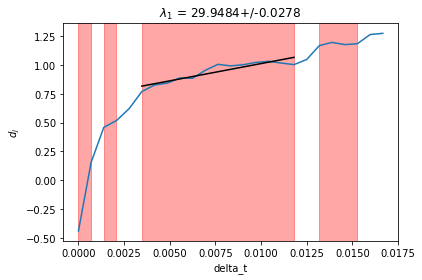

computed in  20.343455 s
Expected time remaining =  4294.0724744166655 s

37 ) Computing  Mon 25 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


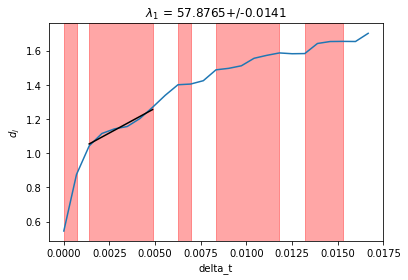

computed in  17.342943 s
Expected time remaining =  4260.008218378377 s

38 ) Computing  Tue 26 Feb 2019 ... 

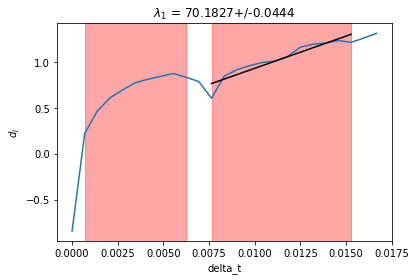

computed in  20.993471000000003 s
Expected time remaining =  4247.478334605262 s

39 ) Computing  Wed 27 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


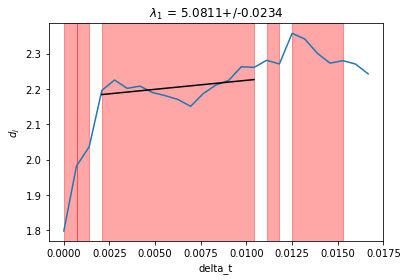

computed in  16.387953 s
Expected time remaining =  4209.243116820512 s

40 ) Computing  Thu 28 Feb 2019 ... 

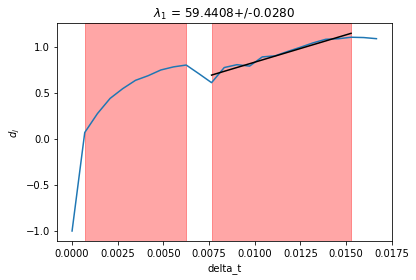

computed in  21.140464 s
Expected time remaining =  4197.40738335 s

41 ) Computing  Fri 01 Mar 2019 ... 

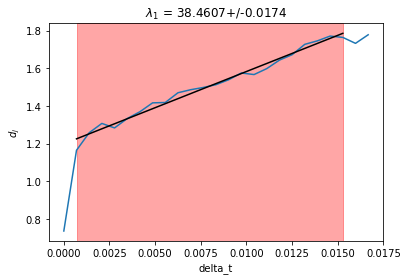

computed in  24.633619 s
Expected time remaining =  4203.179927902438 s

42 ) Computing  Mon 04 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


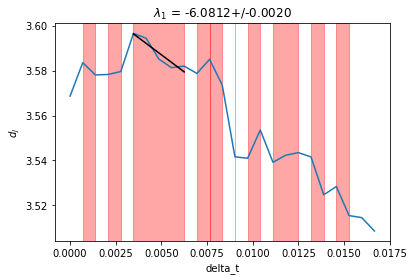

computed in  17.916403000000003 s
Expected time remaining =  4173.7585461904755 s

43 ) Computing  Tue 05 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


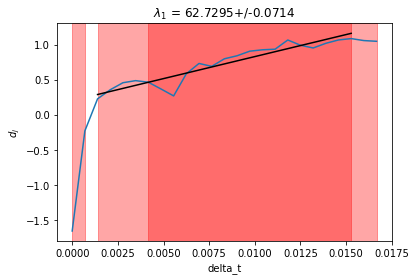

computed in  30.023909000000003 s
Expected time remaining =  4204.001960232557 s

44 ) Computing  Wed 06 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


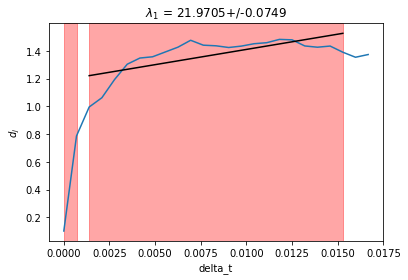

computed in  24.947391 s
Expected time remaining =  4207.392489999999 s

45 ) Computing  Thu 07 Mar 2019 ... 

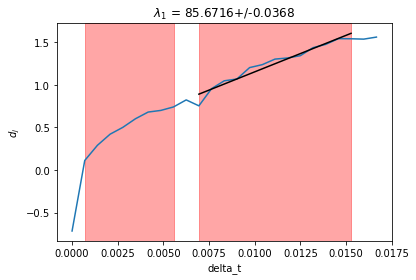

computed in  28.831083000000003 s
Expected time remaining =  4227.474844088889 s

46 ) Computing  Fri 08 Mar 2019 ... 

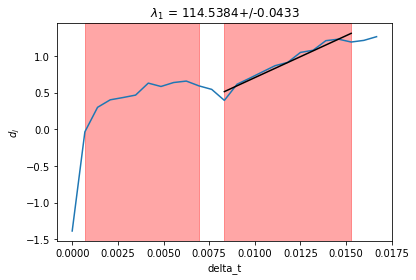

computed in  28.352045000000004 s
Expected time remaining =  4243.274856 s

47 ) Computing  Mon 11 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


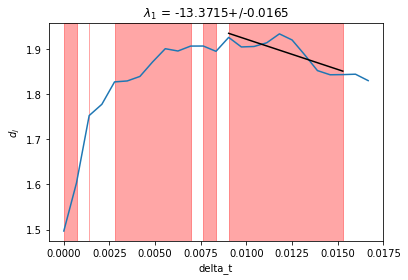

computed in  22.613929000000002 s
Expected time remaining =  4232.046016638297 s

48 ) Computing  Tue 12 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


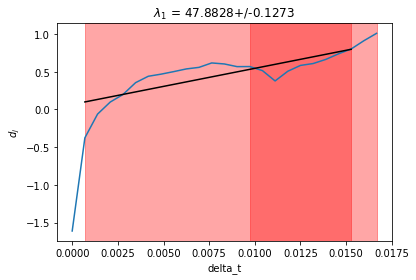

computed in  27.800332000000004 s
Expected time remaining =  4242.493061354167 s

49 ) Computing  Wed 13 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


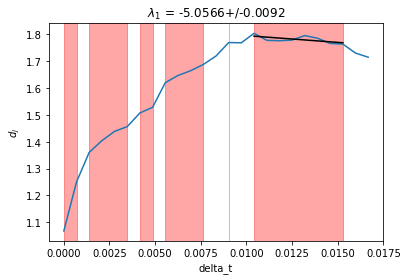

computed in  23.231215000000002 s
Expected time remaining =  4232.356542367347 s

50 ) Computing  Thu 14 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


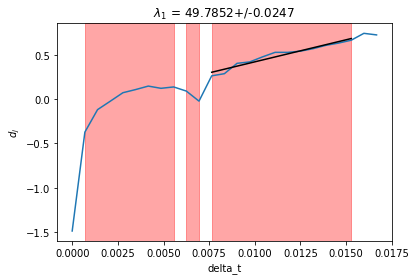

computed in  28.48785 s
Expected time remaining =  4243.0381736399995 s

51 ) Computing  Fri 15 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


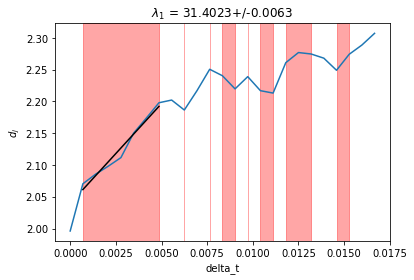

computed in  20.673183 s
Expected time remaining =  4221.231536352942 s

52 ) Computing  Mon 18 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


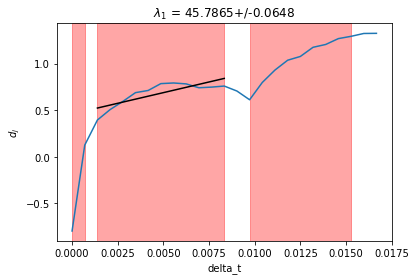

computed in  28.062615000000005 s
Expected time remaining =  4228.03149023077 s

53 ) Computing  Tue 19 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


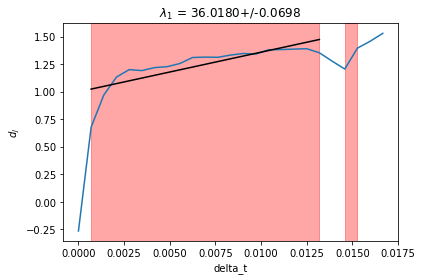

computed in  26.009107000000004 s
Expected time remaining =  4225.766788679246 s

54 ) Computing  Wed 20 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


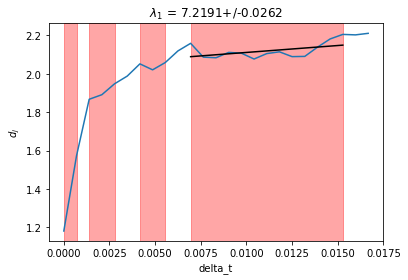

computed in  24.037795 s
Expected time remaining =  4215.358014925927 s

55 ) Computing  Thu 21 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


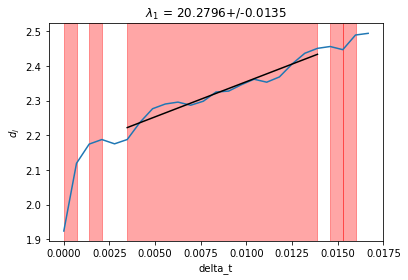

computed in  21.696463 s
Expected time remaining =  4196.0248452000005 s

56 ) Computing  Fri 22 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


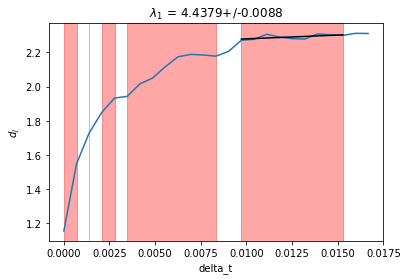

computed in  24.472904 s
Expected time remaining =  4186.374394946429 s

57 ) Computing  Mon 25 Mar 2019 ... 

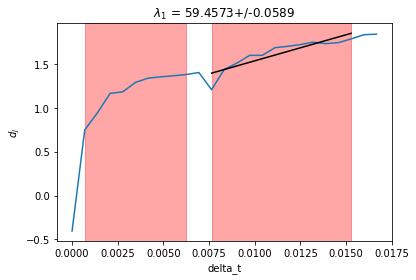

computed in  27.706570000000003 s
Expected time remaining =  4187.323131157895 s

58 ) Computing  Tue 26 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


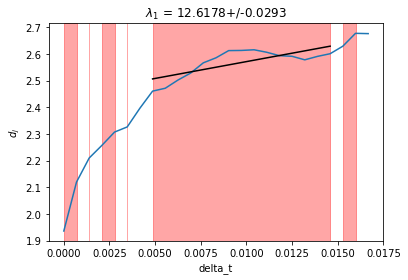

computed in  19.903661 s
Expected time remaining =  4161.0498351724145 s

59 ) Computing  Wed 27 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


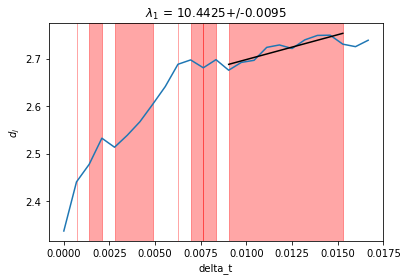

computed in  21.959734000000005 s
Expected time remaining =  4141.753105830509 s

60 ) Computing  Thu 28 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


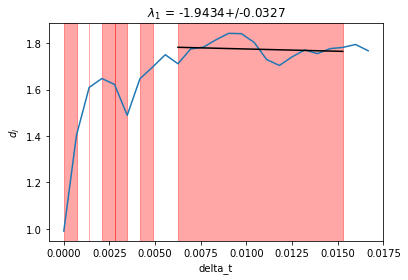

computed in  24.917672 s
Expected time remaining =  4131.882310233334 s

61 ) Computing  Fri 29 Mar 2019 ... 

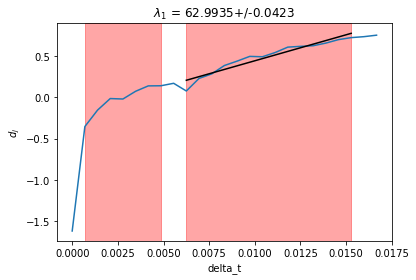

computed in  28.759706 s
Expected time remaining =  4133.61113390164 s

62 ) Computing  Mon 01 Apr 2019 ... 

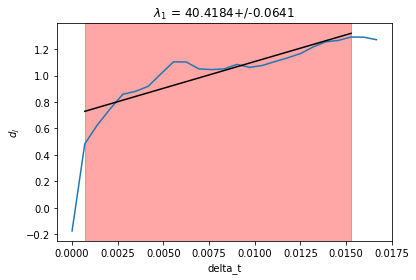

computed in  23.820372000000003 s
Expected time remaining =  4119.140121225806 s

63 ) Computing  Tue 02 Apr 2019 ... 

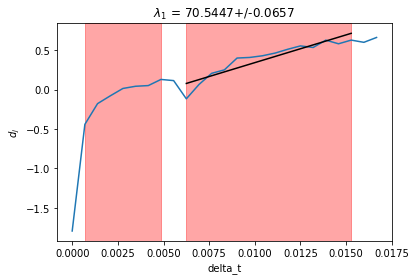

computed in  29.087189000000002 s
Expected time remaining =  4120.256354761906 s

64 ) Computing  Wed 03 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


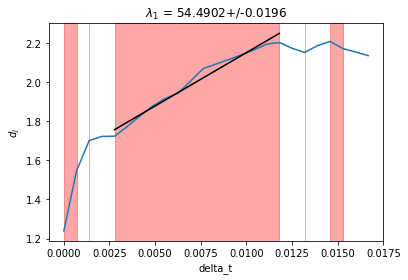

computed in  21.813164 s
Expected time remaining =  4098.947626265624 s

65 ) Computing  Thu 04 Apr 2019 ... 

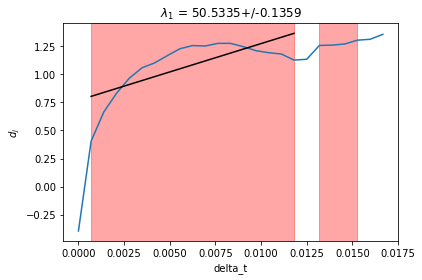

computed in  26.298367000000002 s
Expected time remaining =  4090.595963815384 s

66 ) Computing  Fri 05 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


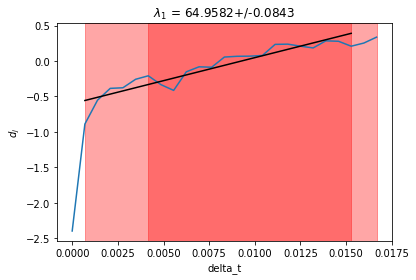

computed in  29.513414 s
Expected time remaining =  4090.809761666667 s

67 ) Computing  Mon 08 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


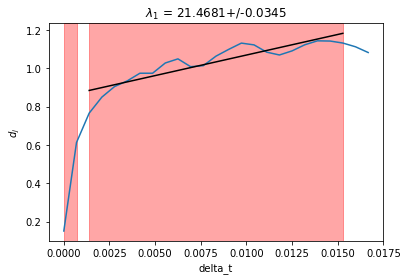

computed in  24.995142 s
Expected time remaining =  4077.5929174925373 s

68 ) Computing  Tue 09 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


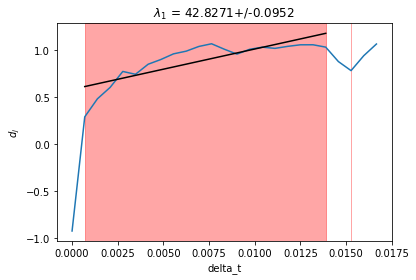

computed in  26.903319 s
Expected time remaining =  4069.2210166911764 s

69 ) Computing  Wed 10 Apr 2019 ... 

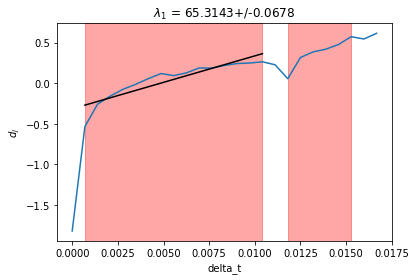

computed in  27.533115000000002 s
Expected time remaining =  4061.991429333333 s

70 ) Computing  Thu 11 Apr 2019 ... 

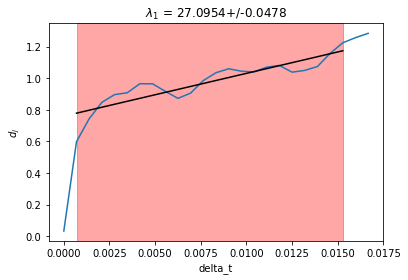

computed in  23.049097 s
Expected time remaining =  4042.459236985714 s

71 ) Computing  Fri 12 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


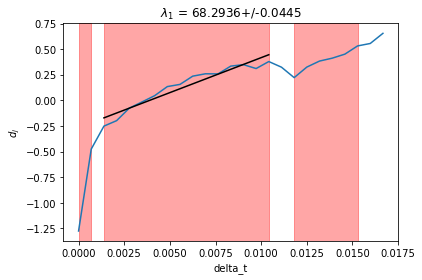

computed in  28.600456 s
Expected time remaining =  4037.0582210985913 s

72 ) Computing  Mon 15 Apr 2019 ... 

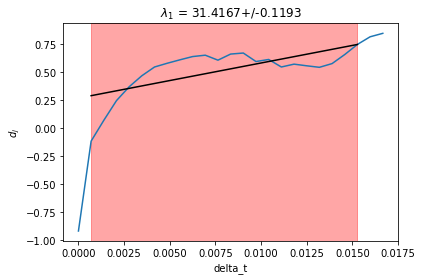

computed in  28.277181000000002 s
Expected time remaining =  4030.200098888889 s

73 ) Computing  Tue 16 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


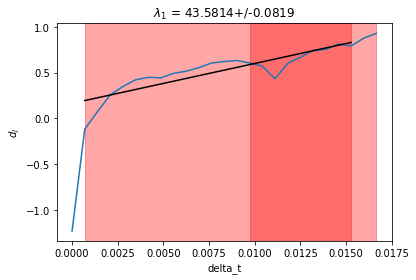

computed in  29.262167 s
Expected time remaining =  4025.183885753425 s

74 ) Computing  Wed 17 Apr 2019 ... 

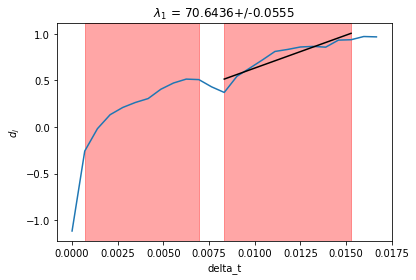

computed in  30.490252 s
Expected time remaining =  4022.4830146081085 s

75 ) Computing  Thu 18 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


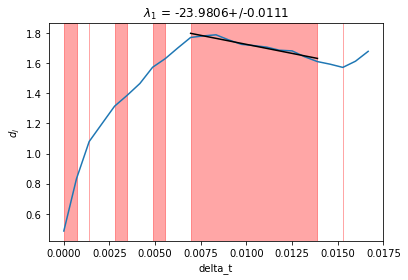

computed in  27.152793000000003 s
Expected time remaining =  4011.1201906133338 s

76 ) Computing  Mon 22 Apr 2019 ... 

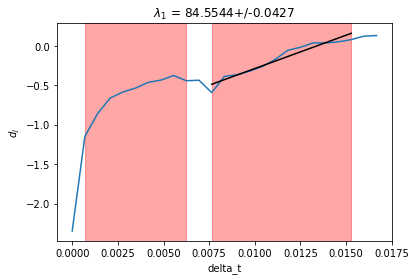

computed in  30.642303000000002 s
Expected time remaining =  4007.468726250001 s

77 ) Computing  Tue 23 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


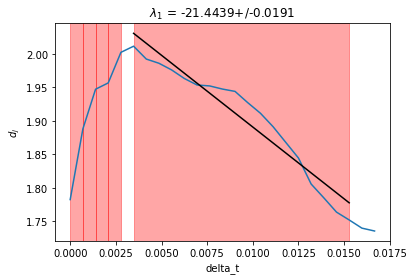

computed in  21.498354 s
Expected time remaining =  3982.215746285715 s

78 ) Computing  Wed 24 Apr 2019 ... 

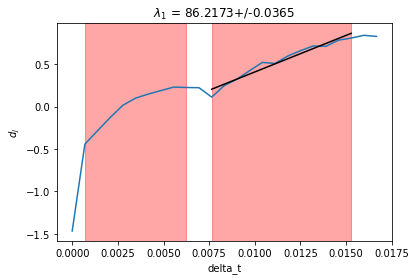

computed in  30.62182 s
Expected time remaining =  3977.5283535256417 s

79 ) Computing  Thu 25 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


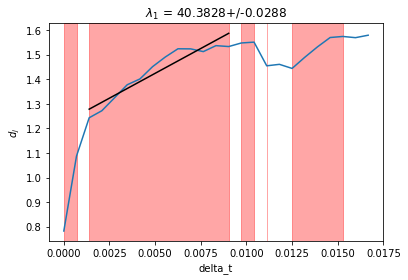

computed in  25.212871 s
Expected time remaining =  3960.27101164557 s

80 ) Computing  Fri 26 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


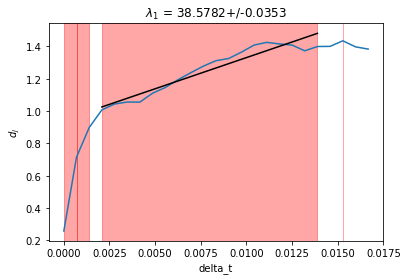

computed in  26.772676000000004 s
Expected time remaining =  3946.1878598500007 s

81 ) Computing  Mon 29 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


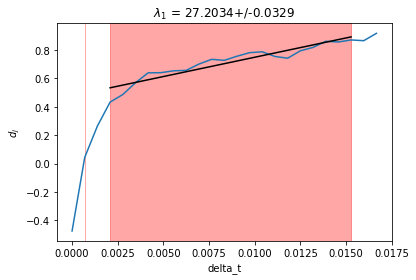

computed in  25.719411 s
Expected time remaining =  3929.5548237530866 s

82 ) Computing  Tue 30 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


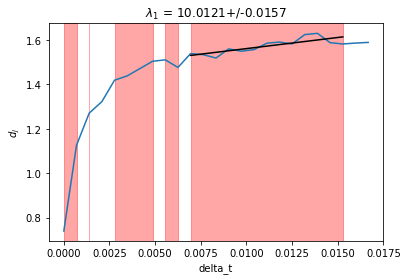

computed in  25.564327000000002 s
Expected time remaining =  3912.3767618780494 s

83 ) Computing  Wed 01 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


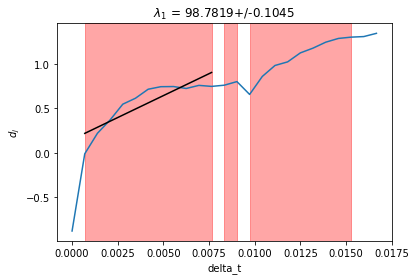

computed in  29.982101000000004 s
Expected time remaining =  3904.045074096386 s

84 ) Computing  Thu 02 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


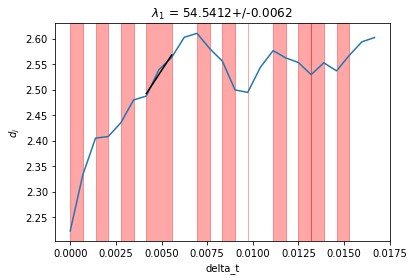

computed in  23.711331 s
Expected time remaining =  3882.581708261905 s

85 ) Computing  Fri 03 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


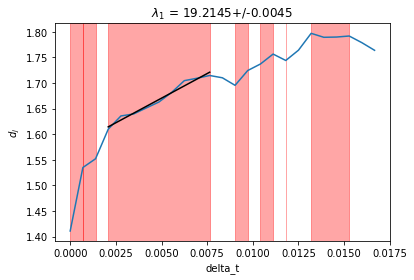

computed in  21.74727 s
Expected time remaining =  3857.1835403294126 s

86 ) Computing  Mon 06 May 2019 ... 

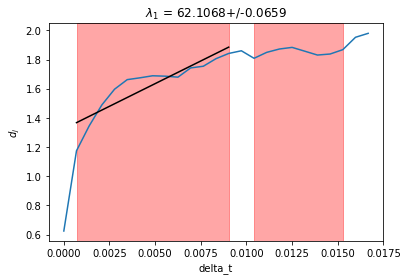

computed in  26.187497 s
Expected time remaining =  3840.4925782674422 s

87 ) Computing  Tue 07 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


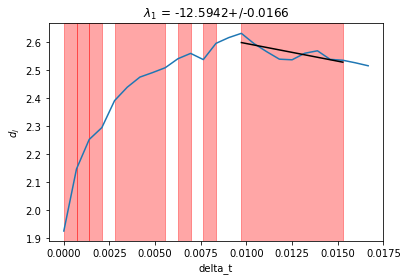

computed in  26.364756 s
Expected time remaining =  3823.9215233793107 s

88 ) Computing  Wed 08 May 2019 ... 

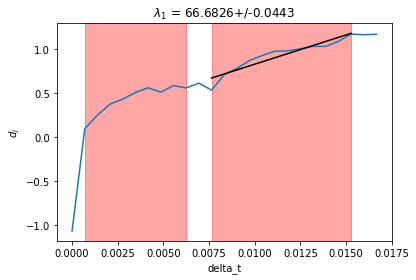

computed in  30.337347 s
Expected time remaining =  3814.5764925000008 s

89 ) Computing  Thu 09 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


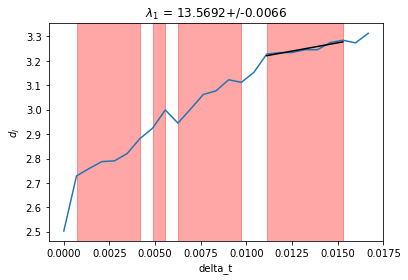

computed in  22.006437000000002 s
Expected time remaining =  3789.408384404495 s

90 ) Computing  Fri 10 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


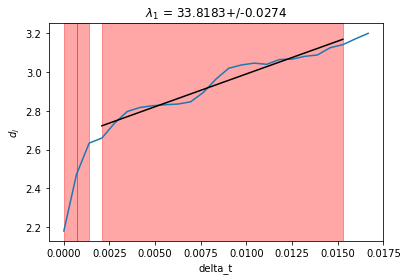

computed in  22.718234000000002 s
Expected time remaining =  3765.5996791222224 s

91 ) Computing  Mon 13 May 2019 ... 

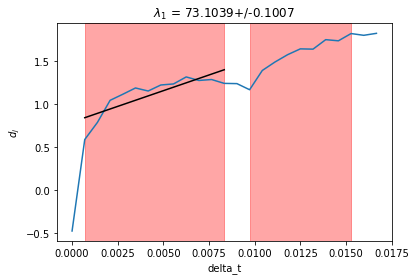

computed in  30.240491000000002 s
Expected time remaining =  3755.206210945056 s

92 ) Computing  Tue 14 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


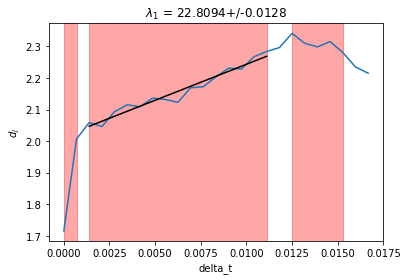

computed in  23.595174 s
Expected time remaining =  3732.751981000001 s

93 ) Computing  Wed 15 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


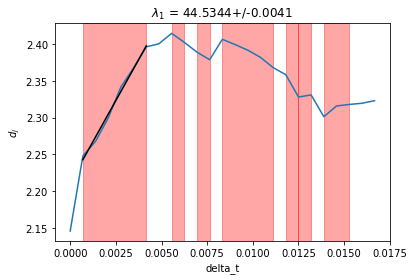

computed in  23.630467000000003 s
Expected time remaining =  3710.333933763441 s

94 ) Computing  Thu 16 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


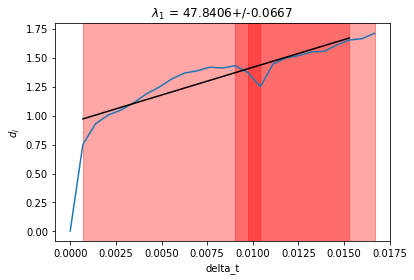

computed in  29.163279 s
Expected time remaining =  3697.2487830000005 s

95 ) Computing  Fri 17 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


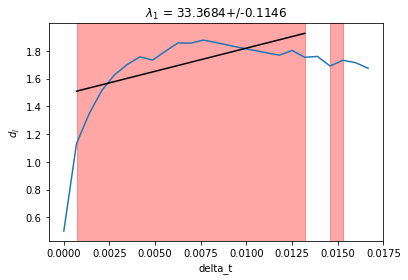

computed in  26.918712000000003 s
Expected time remaining =  3680.0920760000004 s

96 ) Computing  Mon 20 May 2019 ... 

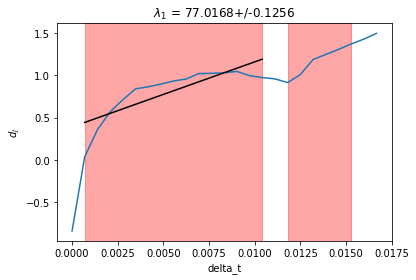

computed in  29.325299 s
Expected time remaining =  3666.667766385416 s

97 ) Computing  Tue 21 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


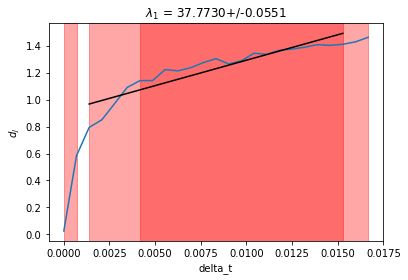

computed in  26.794453 s
Expected time remaining =  3648.845374762887 s

98 ) Computing  Wed 22 May 2019 ... 

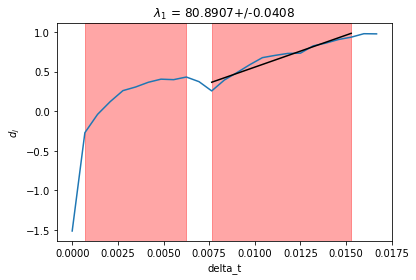

computed in  30.806956 s
Expected time remaining =  3637.186185612244 s

99 ) Computing  Thu 23 May 2019 ... 

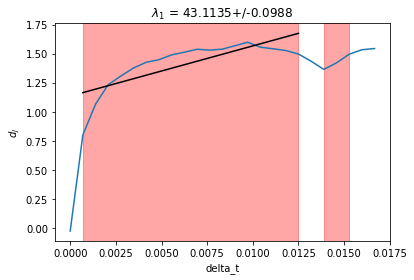

computed in  28.656447 s
Expected time remaining =  3621.794936666666 s

100 ) Computing  Fri 24 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


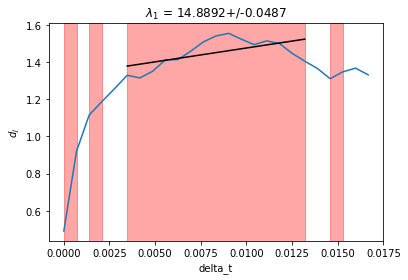

computed in  27.747376000000003 s
Expected time remaining =  3604.747505129999 s

101 ) Computing  Tue 28 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


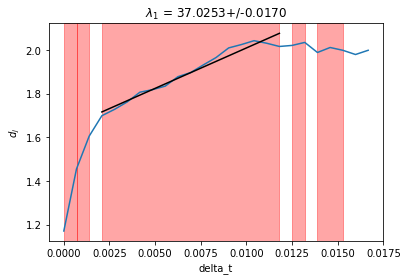

computed in  26.209627 s
Expected time remaining =  3585.1739573861378 s

102 ) Computing  Wed 29 May 2019 ... 

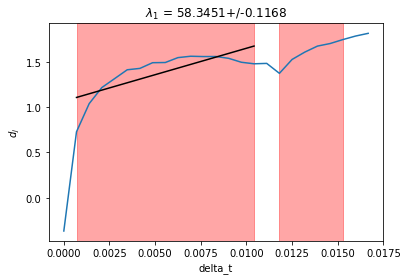

computed in  29.179144000000004 s
Expected time remaining =  3569.866340117647 s

103 ) Computing  Thu 30 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


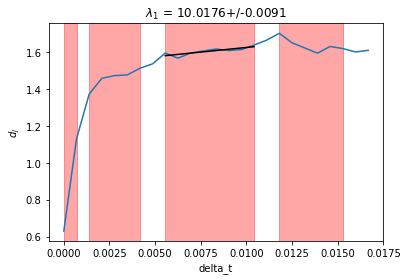

computed in  25.568951000000006 s
Expected time remaining =  3549.031810194175 s

104 ) Computing  Fri 31 May 2019 ... 

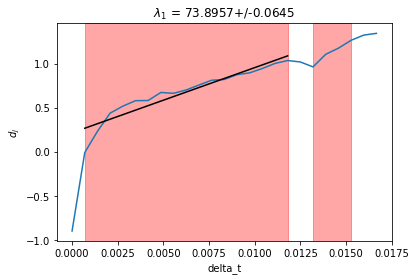

computed in  29.264371999999998 s
Expected time remaining =  3533.400634951923 s

105 ) Computing  Mon 03 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


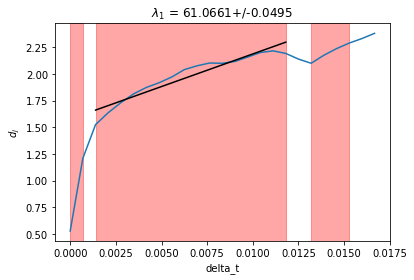

computed in  28.422943000000004 s
Expected time remaining =  3516.323765561905 s

106 ) Computing  Tue 04 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


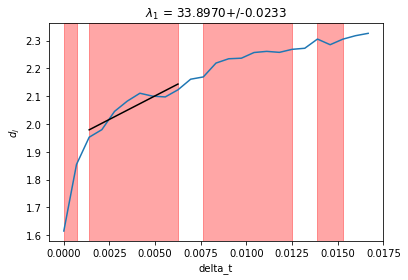

computed in  24.050484 s
Expected time remaining =  3492.9691261698113 s

107 ) Computing  Wed 05 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


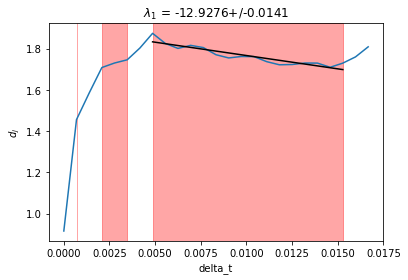

computed in  24.896541000000003 s
Expected time remaining =  3470.7559132523365 s

108 ) Computing  Thu 06 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


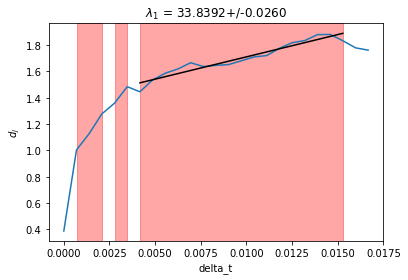

computed in  26.333045000000002 s
Expected time remaining =  3450.4216487037033 s

109 ) Computing  Fri 07 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


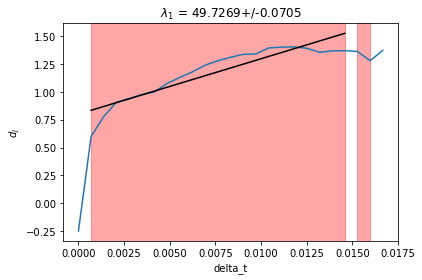

computed in  28.237172000000005 s
Expected time remaining =  3432.4928587155964 s

110 ) Computing  Mon 10 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


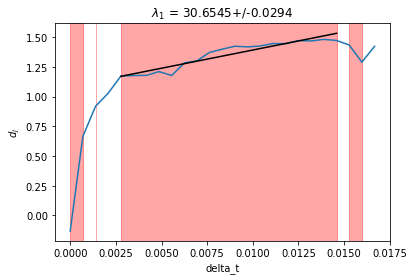

computed in  27.595995 s
Expected time remaining =  3413.5431135 s

111 ) Computing  Tue 11 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


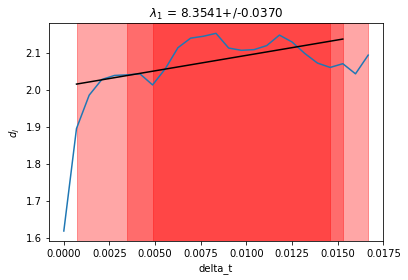

computed in  22.676424 s
Expected time remaining =  3388.144074756757 s

112 ) Computing  Wed 12 Jun 2019 ... 

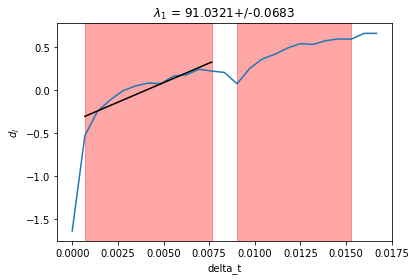

computed in  30.150396 s
Expected time remaining =  3372.202851026786 s

113 ) Computing  Thu 13 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


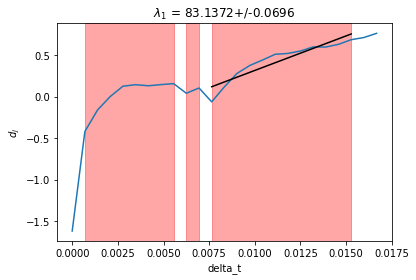

computed in  30.463181000000002 s
Expected time remaining =  3356.3976587610623 s

114 ) Computing  Fri 14 Jun 2019 ... 

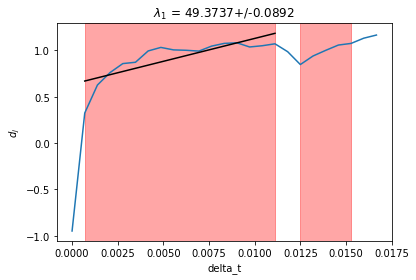

computed in  29.002027000000002 s
Expected time remaining =  3338.553726289474 s

115 ) Computing  Mon 17 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


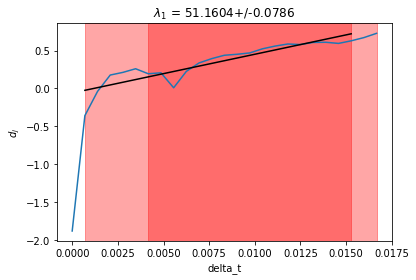

computed in  31.181543 s
Expected time remaining =  3323.131159200001 s

116 ) Computing  Tue 18 Jun 2019 ... 

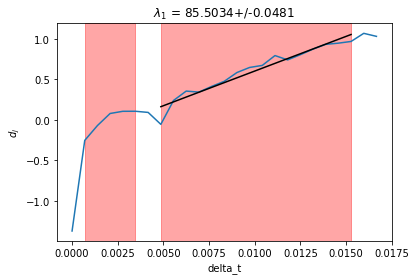

computed in  31.599301000000004 s
Expected time remaining =  3307.9302722327598 s

117 ) Computing  Wed 19 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


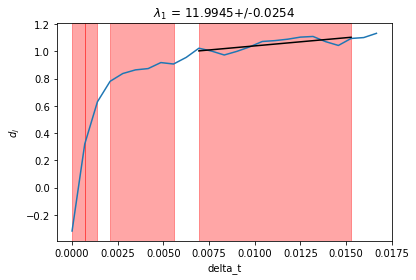

computed in  20.147876 s
Expected time remaining =  3279.138012376069 s

118 ) Computing  Thu 20 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


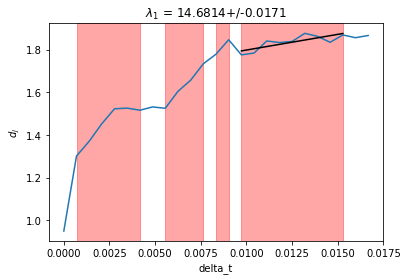

computed in  18.935079 s
Expected time remaining =  3249.1047455084754 s

119 ) Computing  Fri 21 Jun 2019 ... 

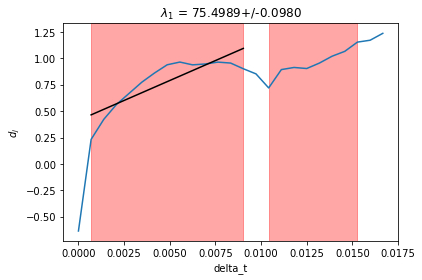

computed in  22.177488 s
Expected time remaining =  3222.9091188235298 s

120 ) Computing  Mon 24 Jun 2019 ... 

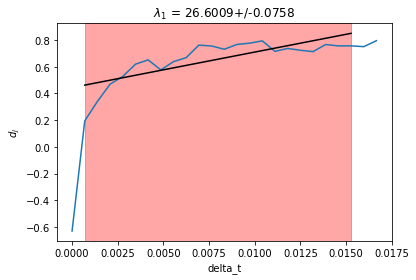

computed in  19.960774 s
Expected time remaining =  3194.3236031 s

121 ) Computing  Tue 25 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


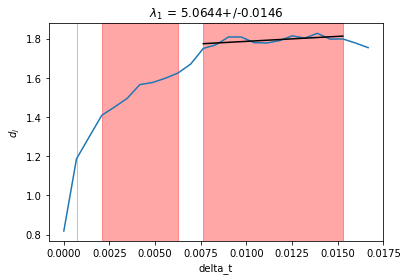

computed in  20.235145000000003 s
Expected time remaining =  3166.179958909091 s

122 ) Computing  Wed 26 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


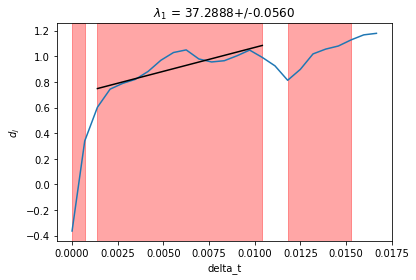

computed in  21.738810000000004 s
Expected time remaining =  3139.780553352459 s

123 ) Computing  Thu 27 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


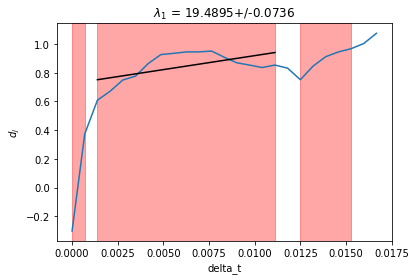

computed in  21.757400000000004 s
Expected time remaining =  3113.476577804878 s

124 ) Computing  Fri 28 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


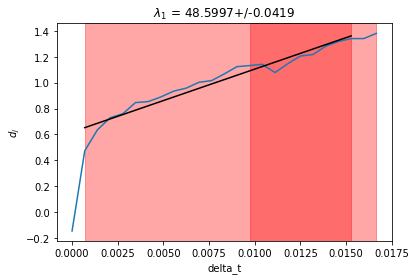

computed in  22.071018 s
Expected time remaining =  3087.572198008065 s

125 ) Computing  Mon 01 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


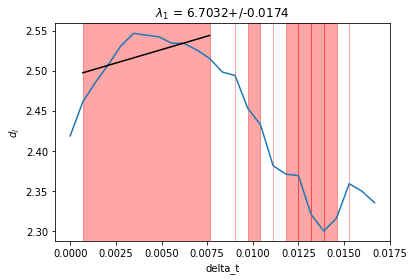

computed in  17.191647 s
Expected time remaining =  3056.7326760960004 s

126 ) Computing  Tue 02 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


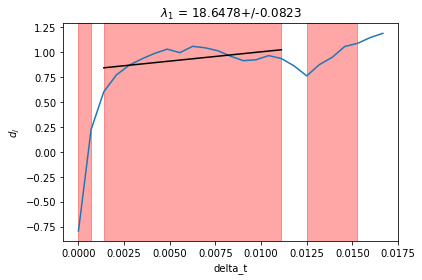

computed in  22.086471 s
Expected time remaining =  3031.0434589285715 s

127 ) Computing  Wed 03 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


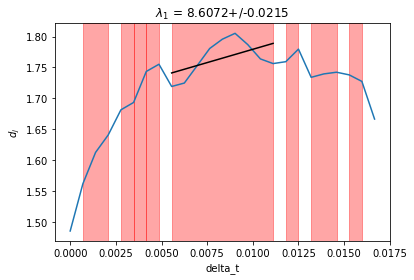

computed in  6.837545 s
Expected time remaining =  2990.2821222047246 s

128 ) Computing  Fri 05 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


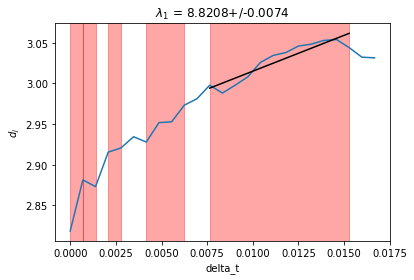

computed in  14.35945 s
Expected time remaining =  2957.3964550781257 s

129 ) Computing  Mon 08 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


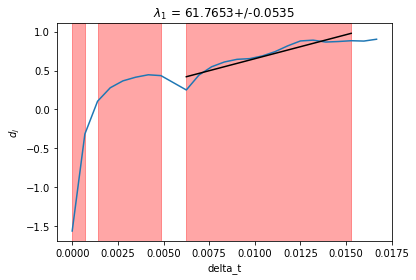

computed in  23.419527000000002 s
Expected time remaining =  2933.506927348837 s

130 ) Computing  Tue 09 Jul 2019 ... 

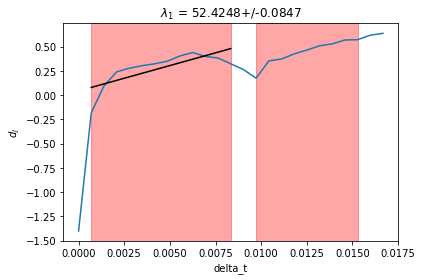

computed in  22.939894000000002 s
Expected time remaining =  2909.170823792308 s

131 ) Computing  Wed 10 Jul 2019 ... 

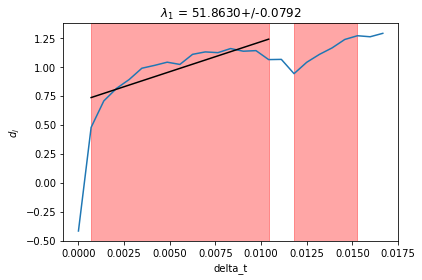

computed in  21.606855000000003 s
Expected time remaining =  2883.614580244275 s

132 ) Computing  Thu 11 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


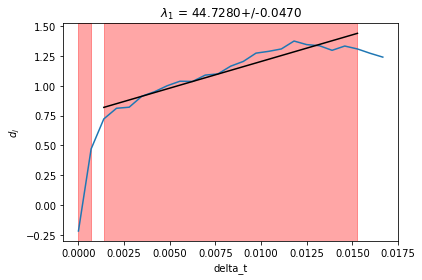

computed in  19.53323 s
Expected time remaining =  2856.217353 s

133 ) Computing  Fri 12 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


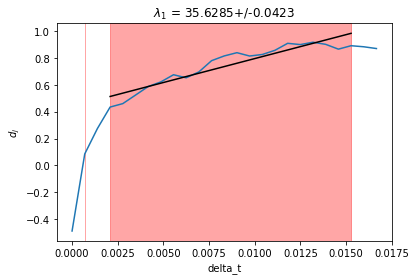

computed in  21.003348000000003 s
Expected time remaining =  2830.2648036090222 s

134 ) Computing  Mon 15 Jul 2019 ... 

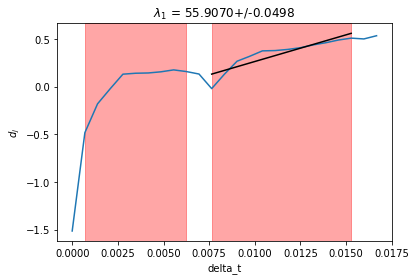

computed in  23.328767 s
Expected time remaining =  2806.4512337985075 s

135 ) Computing  Tue 16 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


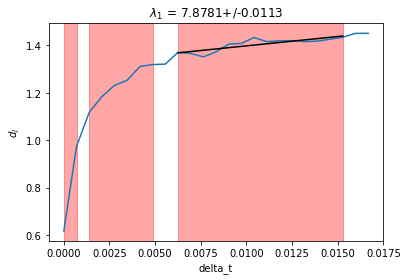

computed in  18.762152 s
Expected time remaining =  2778.653286474074 s

136 ) Computing  Wed 17 Jul 2019 ... 

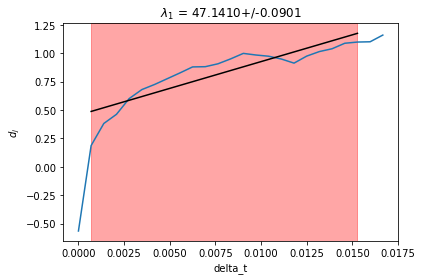

computed in  22.450145 s
Expected time remaining =  2754.1609771764706 s

137 ) Computing  Thu 18 Jul 2019 ... 

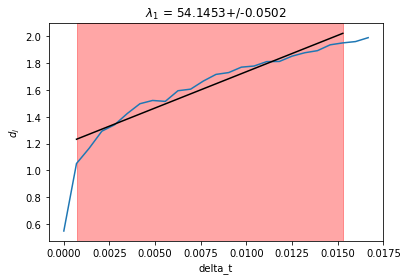

computed in  18.916304 s
Expected time remaining =  2726.7063231532848 s

138 ) Computing  Fri 19 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


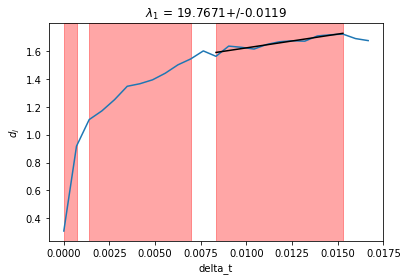

computed in  20.466267000000002 s
Expected time remaining =  2700.6670491666664 s

139 ) Computing  Mon 22 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


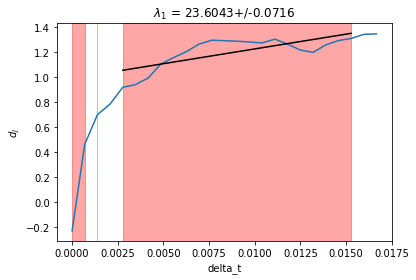

computed in  21.255775000000003 s
Expected time remaining =  2675.3554724892088 s

140 ) Computing  Tue 23 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


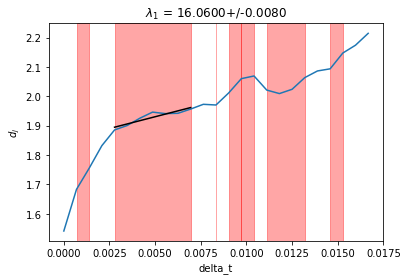

computed in  16.740841000000003 s
Expected time remaining =  2646.457639107143 s

141 ) Computing  Wed 24 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


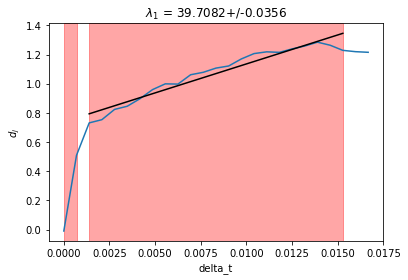

computed in  20.717077 s
Expected time remaining =  2620.890673929078 s

142 ) Computing  Thu 25 Jul 2019 ... 

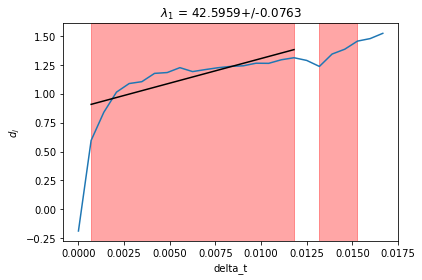

computed in  21.780129000000002 s
Expected time remaining =  2596.2229943028174 s

143 ) Computing  Fri 26 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


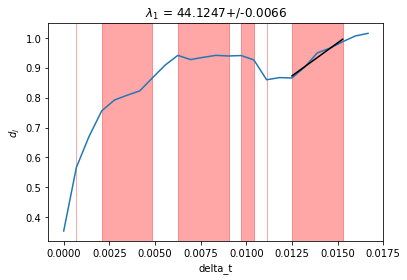

computed in  18.906827 s
Expected time remaining =  2569.385467692308 s

144 ) Computing  Mon 29 Jul 2019 ... 

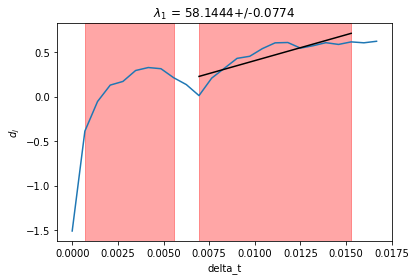

computed in  23.241404000000003 s
Expected time remaining =  2545.939123666667 s

145 ) Computing  Tue 30 Jul 2019 ... 

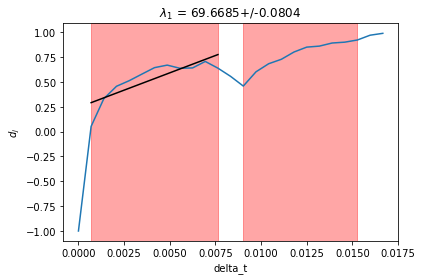

computed in  22.743823000000003 s
Expected time remaining =  2522.124994344828 s

146 ) Computing  Wed 31 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


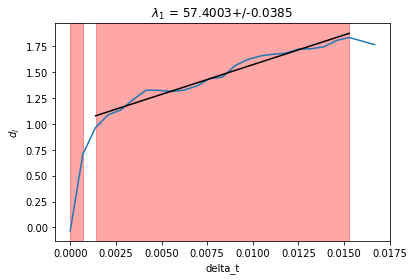

computed in  20.712105 s
Expected time remaining =  2496.8365279452055 s

147 ) Computing  Thu 01 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


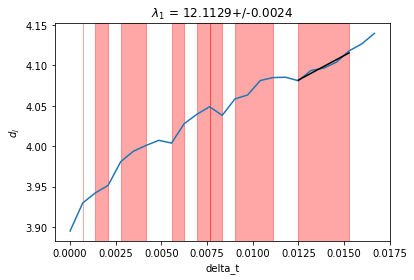

computed in  14.215625 s
Expected time remaining =  2466.925788367347 s

148 ) Computing  Fri 02 Aug 2019 ... 

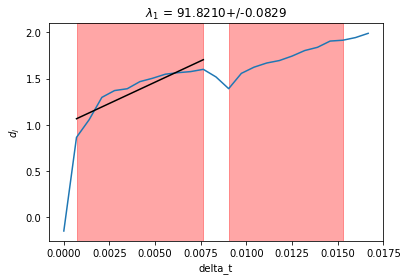

computed in  22.321988000000005 s
Expected time remaining =  2442.978280844595 s

149 ) Computing  Mon 05 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


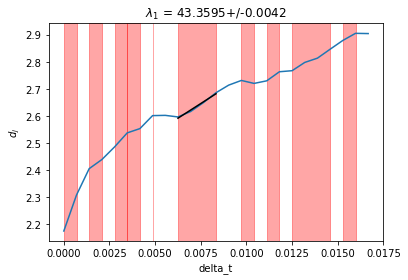

computed in  18.278124000000002 s
Expected time remaining =  2416.2300295838922 s

150 ) Computing  Tue 06 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


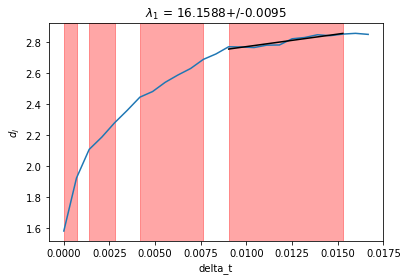

computed in  18.250673000000003 s
Expected time remaining =  2389.575863666667 s

151 ) Computing  Wed 07 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


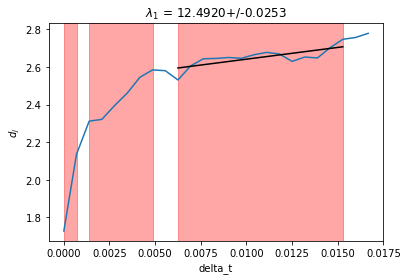

computed in  19.412416999999998 s
Expected time remaining =  2363.817756516556 s

152 ) Computing  Thu 08 Aug 2019 ... 

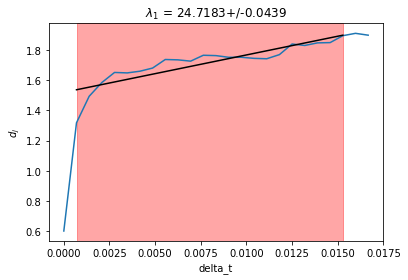

computed in  19.862305 s
Expected time remaining =  2338.442084026316 s

153 ) Computing  Fri 09 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


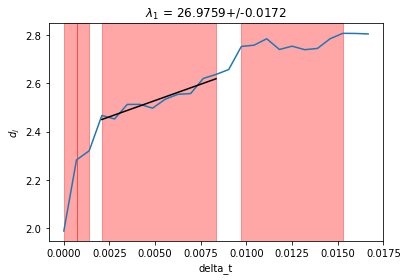

computed in  18.928279 s
Expected time remaining =  2312.5280071895427 s

154 ) Computing  Mon 12 Aug 2019 ... 

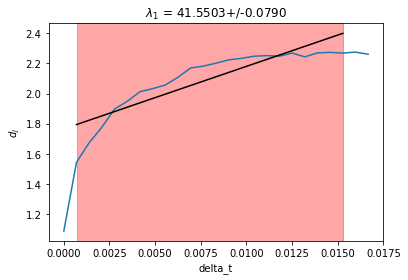

computed in  18.868934 s
Expected time remaining =  2286.666504642857 s

155 ) Computing  Tue 13 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


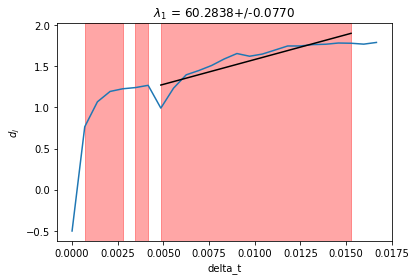

computed in  21.851732 s
Expected time remaining =  2262.7811268774194 s

156 ) Computing  Wed 14 Aug 2019 ... 

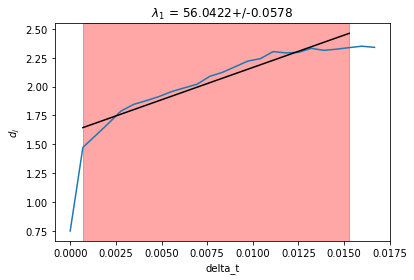

computed in  20.383645 s
Expected time remaining =  2238.008972525641 s

157 ) Computing  Thu 15 Aug 2019 ... 

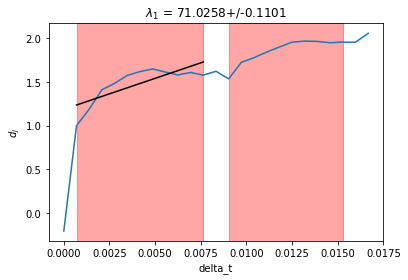

computed in  20.207755000000002 s
Expected time remaining =  2213.185172178344 s

158 ) Computing  Fri 16 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


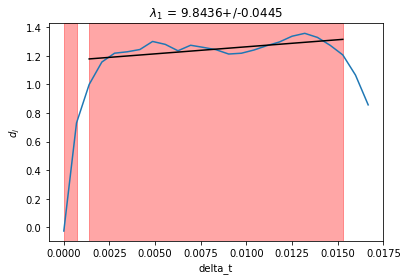

computed in  20.990388000000003 s
Expected time remaining =  2188.890373259494 s

159 ) Computing  Mon 19 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


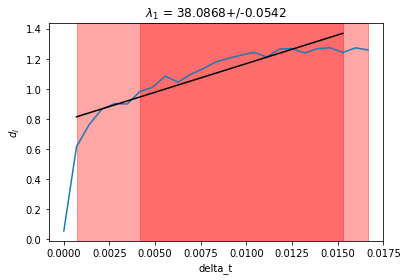

computed in  20.81143 s
Expected time remaining =  2164.5313401886797 s

160 ) Computing  Tue 20 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


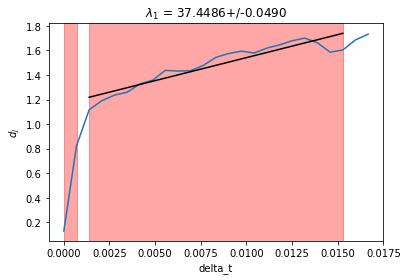

computed in  21.454002000000003 s
Expected time remaining =  2140.59014713125 s

161 ) Computing  Wed 21 Aug 2019 ... 

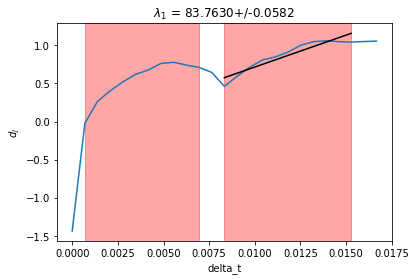

computed in  23.026464 s
Expected time remaining =  2117.5784005714286 s

162 ) Computing  Thu 22 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


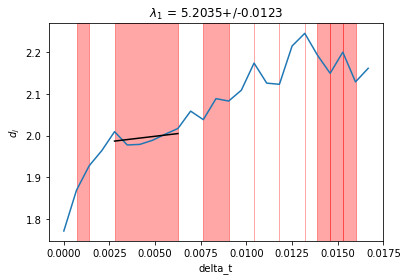

computed in  19.726123 s
Expected time remaining =  2092.712577061728 s

163 ) Computing  Fri 23 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


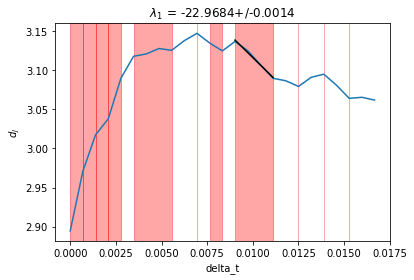

computed in  17.981285 s
Expected time remaining =  2066.9464098773005 s

164 ) Computing  Mon 26 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


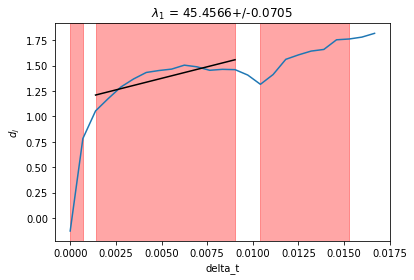

computed in  22.305934000000004 s
Expected time remaining =  2043.622093457317 s

165 ) Computing  Tue 27 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


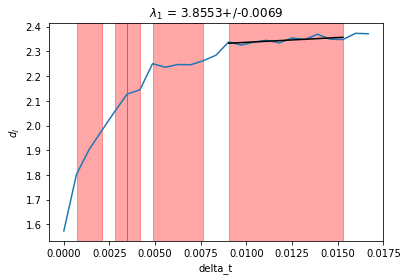

computed in  19.190901 s
Expected time remaining =  2018.6487701333335 s

166 ) Computing  Wed 28 Aug 2019 ... 

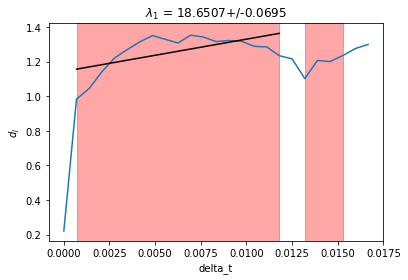

computed in  21.377548 s
Expected time remaining =  1994.8911283373493 s

167 ) Computing  Thu 29 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


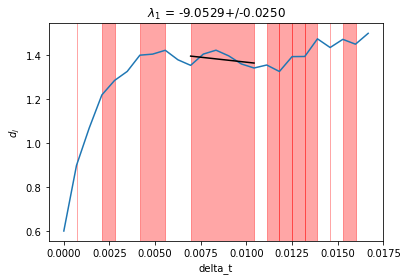

computed in  19.276301 s
Expected time remaining =  1970.0799113652695 s

168 ) Computing  Fri 30 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


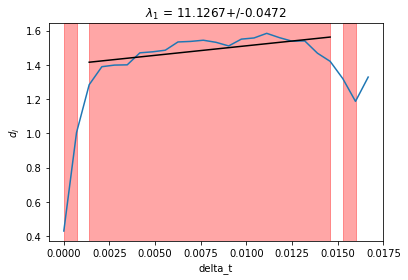

computed in  20.329043000000002 s
Expected time remaining =  1945.8672235714287 s

169 ) Computing  Tue 03 Sep 2019 ... 

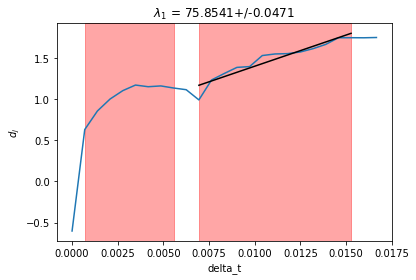

computed in  23.024243000000002 s
Expected time remaining =  1923.040122106509 s

170 ) Computing  Wed 04 Sep 2019 ... 

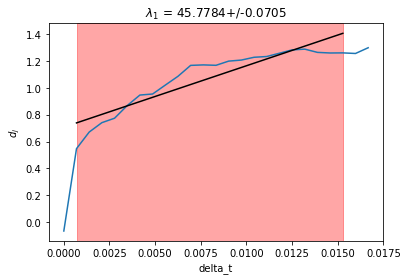

computed in  19.911315000000002 s
Expected time remaining =  1898.6908600117645 s

171 ) Computing  Thu 05 Sep 2019 ... 

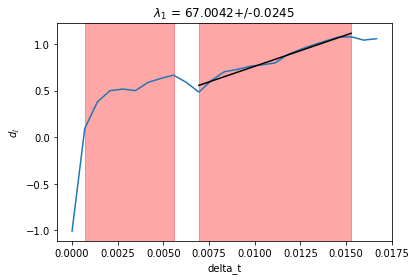

computed in  23.706025000000004 s
Expected time remaining =  1876.2131892280702 s

172 ) Computing  Fri 06 Sep 2019 ... 

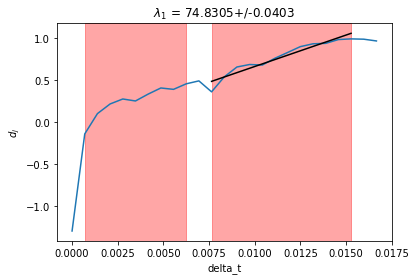

computed in  22.741961000000003 s
Expected time remaining =  1853.267228372093 s

173 ) Computing  Mon 09 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


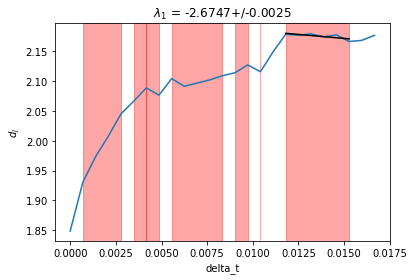

computed in  16.85788 s
Expected time remaining =  1827.6026635838152 s

174 ) Computing  Tue 10 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


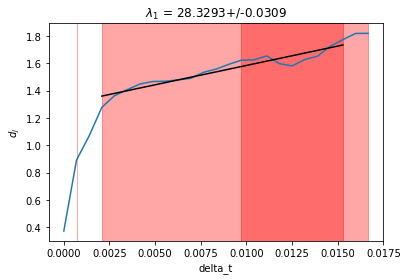

computed in  21.134096 s
Expected time remaining =  1803.9808254252875 s

175 ) Computing  Wed 11 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


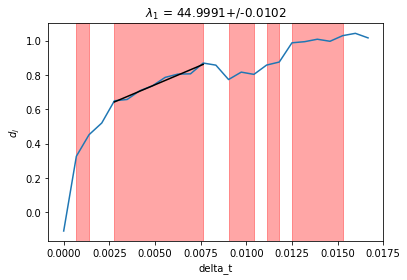

computed in  275.813776 s
Expected time remaining =  1893.9017902628573 s

176 ) Computing  Thu 12 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


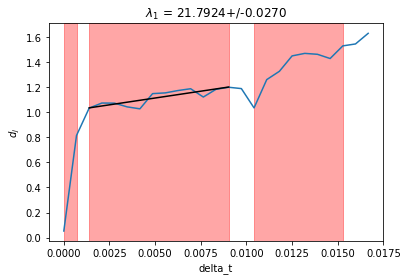

computed in  23.331231 s
Expected time remaining =  1869.2055650625 s

177 ) Computing  Fri 13 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


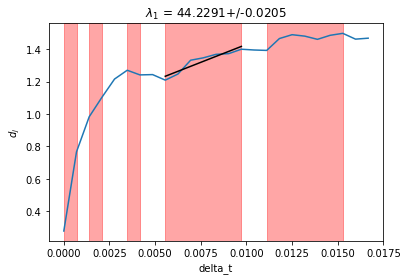

computed in  20.413401 s
Expected time remaining =  1843.2719099661017 s

178 ) Computing  Mon 16 Sep 2019 ... 

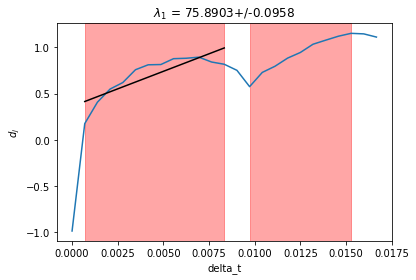

computed in  22.424069000000003 s
Expected time remaining =  1818.2474717696632 s

179 ) Computing  Tue 17 Sep 2019 ... 

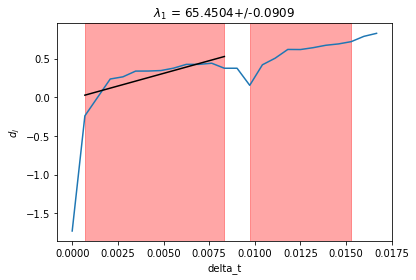

computed in  21.942701 s
Expected time remaining =  1793.0530866815643 s

180 ) Computing  Wed 18 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


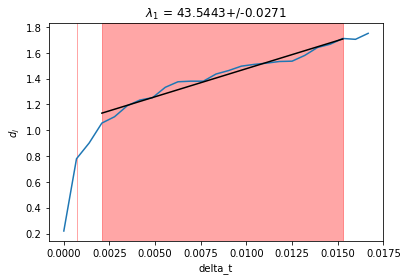

computed in  19.518431 s
Expected time remaining =  1766.9116552500004 s

181 ) Computing  Thu 19 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


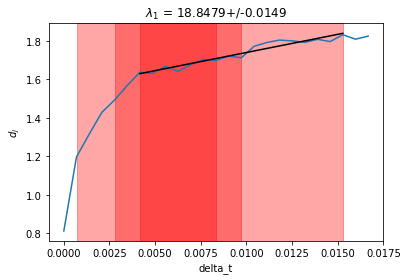

computed in  18.173656 s
Expected time remaining =  1740.3084680220995 s

182 ) Computing  Fri 20 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


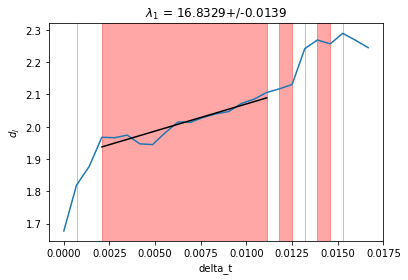

computed in  18.096334000000002 s
Expected time remaining =  1713.7677489285713 s

183 ) Computing  Mon 23 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


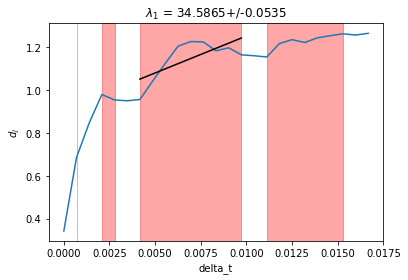

computed in  17.692062000000004 s
Expected time remaining =  1687.1646786338797 s

184 ) Computing  Tue 24 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


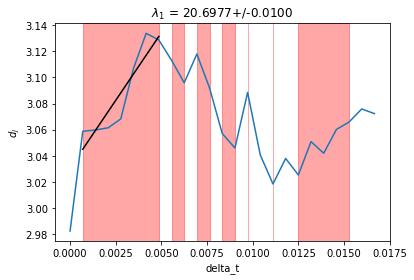

computed in  15.543407000000002 s
Expected time remaining =  1659.8527215000006 s

185 ) Computing  Wed 25 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


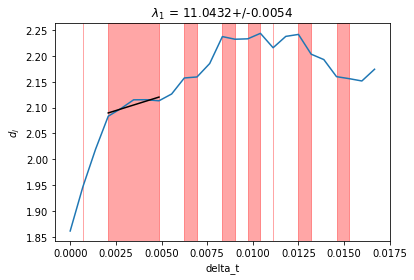

computed in  17.094679 s
Expected time remaining =  1633.238189210811 s

186 ) Computing  Thu 26 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


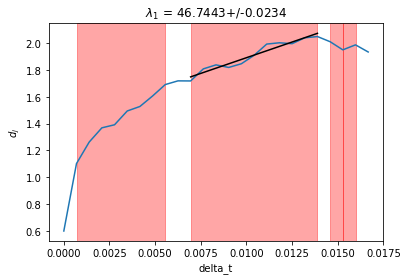

computed in  18.554211000000002 s
Expected time remaining =  1607.2517663333333 s

187 ) Computing  Fri 27 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


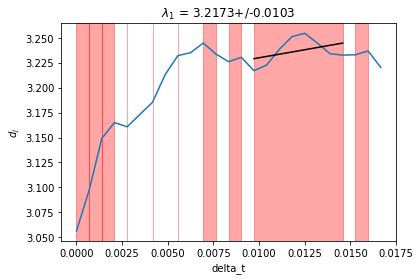

computed in  15.147523000000001 s
Expected time remaining =  1580.1424718823532 s

188 ) Computing  Mon 30 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


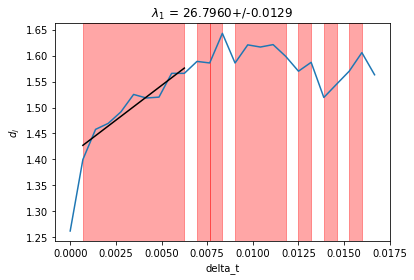

computed in  16.61746 s
Expected time remaining =  1553.6686532180852 s

189 ) Computing  Tue 01 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


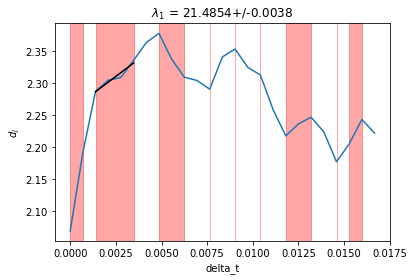

computed in  18.302057 s
Expected time remaining =  1527.8695801904764 s

190 ) Computing  Wed 02 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


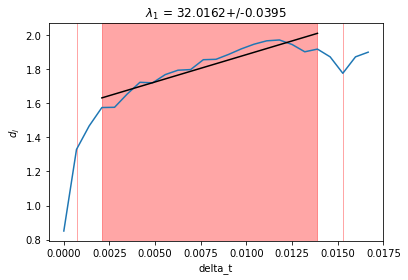

computed in  19.571687 s
Expected time remaining =  1502.5704057000005 s

191 ) Computing  Thu 03 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


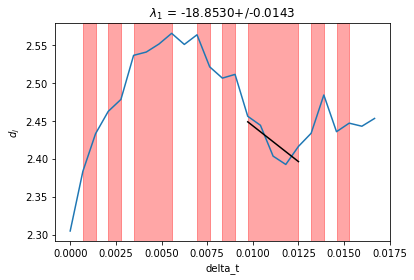

computed in  17.822448 s
Expected time remaining =  1476.7633890994764 s

192 ) Computing  Fri 04 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


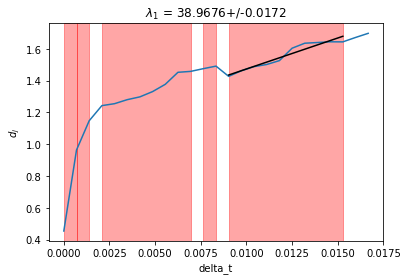

computed in  19.25284 s
Expected time remaining =  1451.4939925468755 s

193 ) Computing  Mon 07 Oct 2019 ... 

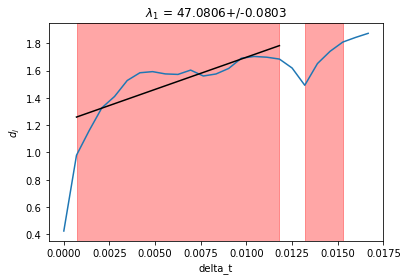

computed in  19.064182000000002 s
Expected time remaining =  1426.22829357513 s

194 ) Computing  Tue 08 Oct 2019 ... 

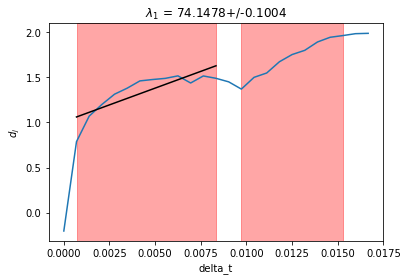

computed in  21.18536 s
Expected time remaining =  1401.6716282938146 s

195 ) Computing  Wed 09 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


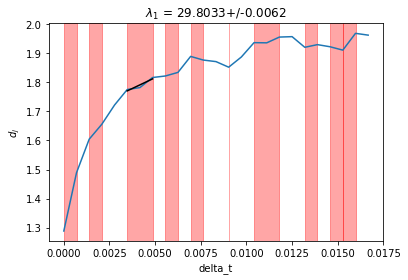

computed in  17.847848000000003 s
Expected time remaining =  1376.156844625641 s

196 ) Computing  Thu 10 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


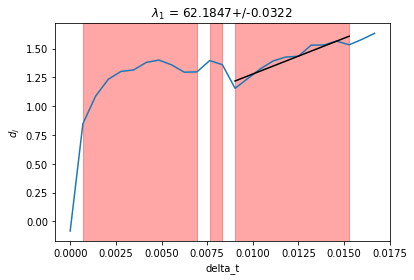

computed in  20.888342 s
Expected time remaining =  1351.6045202908165 s

197 ) Computing  Fri 11 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


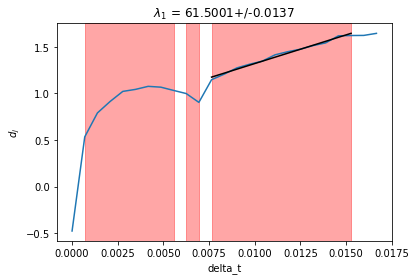

computed in  21.039605 s
Expected time remaining =  1327.1323923654822 s

198 ) Computing  Mon 14 Oct 2019 ... 

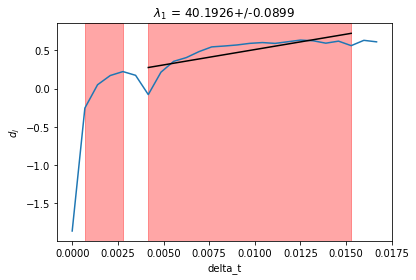

computed in  22.298882 s
Expected time remaining =  1303.044735555556 s

199 ) Computing  Tue 15 Oct 2019 ... 

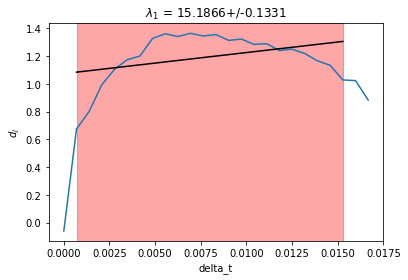

computed in  18.687952000000003 s
Expected time remaining =  1277.9952060301512 s

200 ) Computing  Wed 16 Oct 2019 ... 

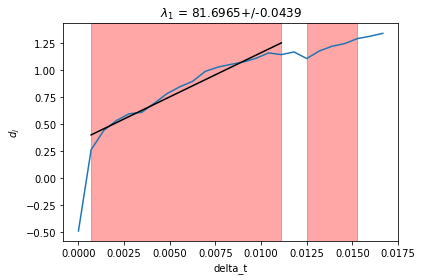

computed in  19.466048000000004 s
Expected time remaining =  1253.21548772 s

201 ) Computing  Thu 17 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


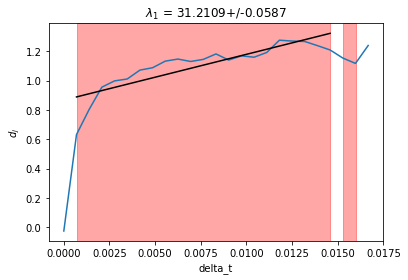

computed in  18.886818 s
Expected time remaining =  1228.3387912039802 s

202 ) Computing  Fri 18 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


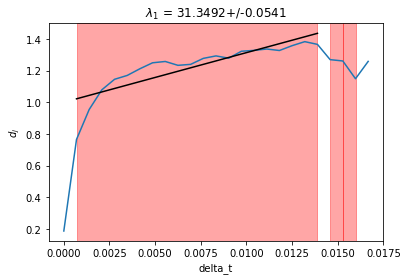

computed in  18.918092 s
Expected time remaining =  1203.529296326733 s

203 ) Computing  Mon 21 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


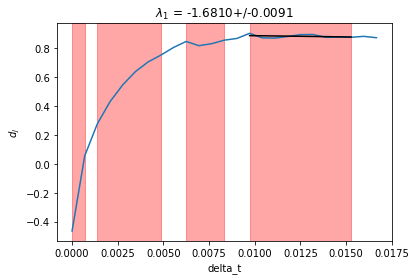

computed in  19.433085000000002 s
Expected time remaining =  1178.9046903940887 s

204 ) Computing  Tue 22 Oct 2019 ... 

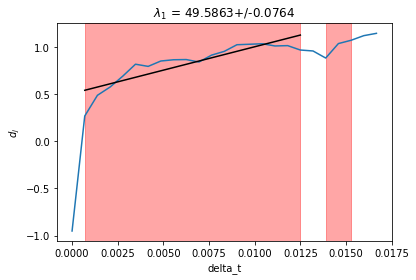

computed in  19.706779 s
Expected time remaining =  1154.3967219509805 s

205 ) Computing  Wed 23 Oct 2019 ... 

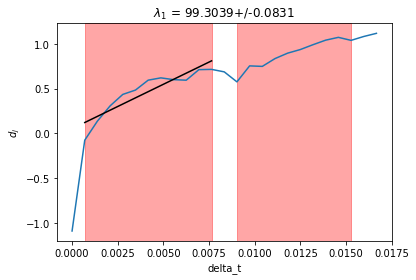

computed in  21.261785000000003 s
Expected time remaining =  1130.2996933463414 s

206 ) Computing  Thu 24 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


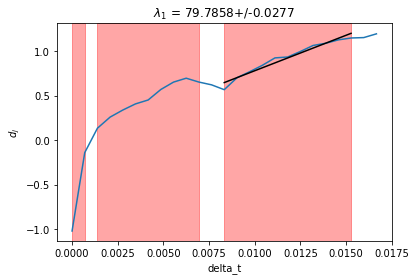

computed in  20.56275 s
Expected time remaining =  1106.07070281068 s

207 ) Computing  Fri 25 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


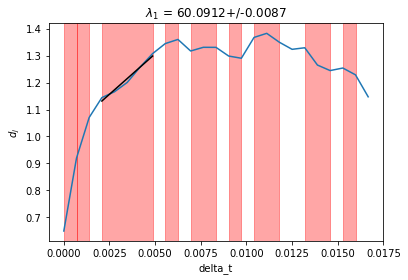

computed in  18.804473 s
Expected time remaining =  1081.4864066666669 s

208 ) Computing  Mon 28 Oct 2019 ... 

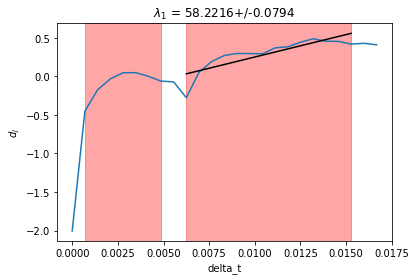

computed in  22.159632000000002 s
Expected time remaining =  1057.6835614903846 s

209 ) Computing  Tue 29 Oct 2019 ... 

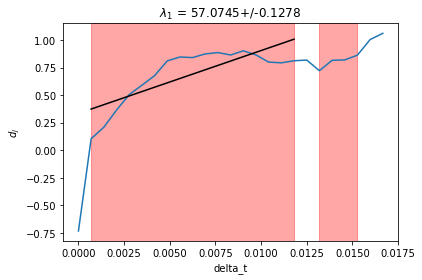

computed in  19.006844 s
Expected time remaining =  1033.232696 s

210 ) Computing  Wed 30 Oct 2019 ... 

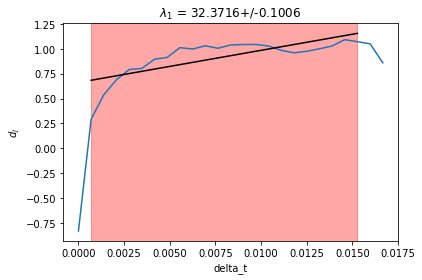

computed in  18.620835 s
Expected time remaining =  1008.7546383952383 s

211 ) Computing  Thu 31 Oct 2019 ... 

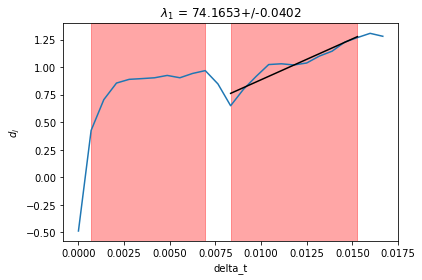

computed in  20.664040000000004 s
Expected time remaining =  984.7388038009481 s

212 ) Computing  Fri 01 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


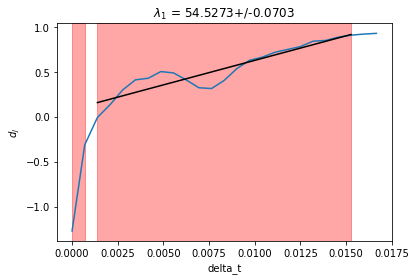

computed in  21.736424 s
Expected time remaining =  960.9619849292455 s

213 ) Computing  Mon 04 Nov 2019 ... 

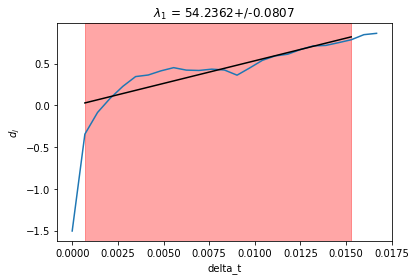

computed in  20.989124 s
Expected time remaining =  937.0639866666669 s

214 ) Computing  Tue 05 Nov 2019 ... 

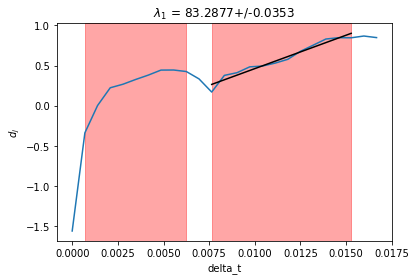

computed in  21.541765 s
Expected time remaining =  913.293889093458 s

215 ) Computing  Wed 06 Nov 2019 ... 

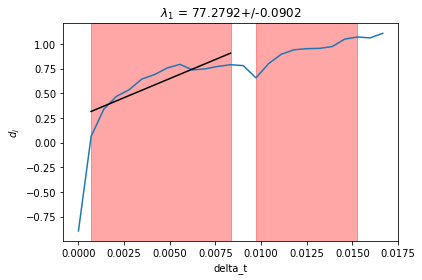

computed in  20.469229000000002 s
Expected time remaining =  889.3549556930235 s

216 ) Computing  Thu 07 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


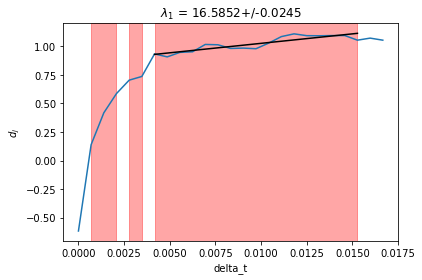

computed in  18.189461 s
Expected time remaining =  865.0576333703702 s

217 ) Computing  Fri 08 Nov 2019 ... 

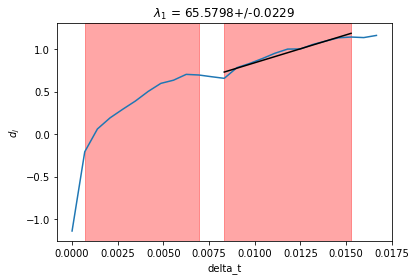

computed in  21.356699000000003 s
Expected time remaining =  841.3420451059907 s

218 ) Computing  Mon 11 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


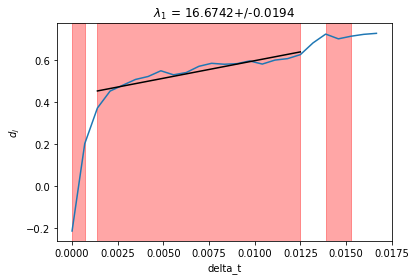

computed in  18.546267 s
Expected time remaining =  817.1968818807338 s

219 ) Computing  Tue 12 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


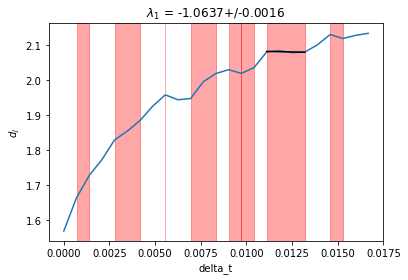

computed in  16.118737 s
Expected time remaining =  792.7259733242008 s

220 ) Computing  Wed 13 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


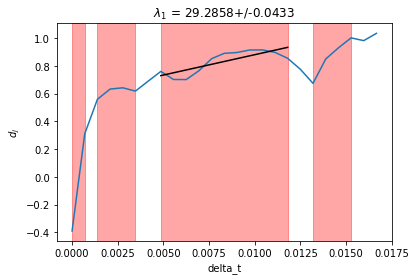

computed in  20.256058 s
Expected time remaining =  768.95159175 s

221 ) Computing  Thu 14 Nov 2019 ... 

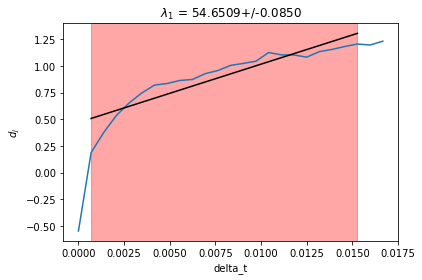

computed in  19.725618 s
Expected time remaining =  745.1322444162895 s

222 ) Computing  Fri 15 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


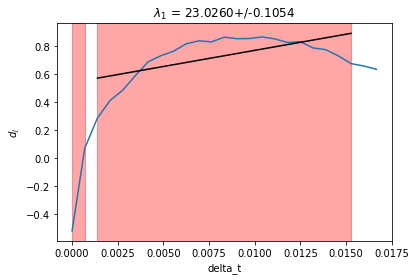

computed in  19.421749000000002 s
Expected time remaining =  721.3073453693694 s

223 ) Computing  Mon 18 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


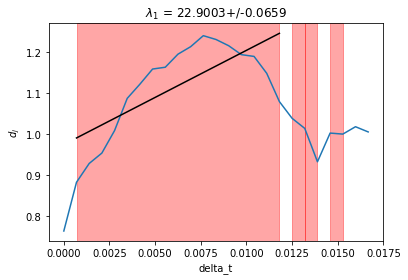

computed in  16.941899 s
Expected time remaining =  697.1883243497757 s

224 ) Computing  Tue 19 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


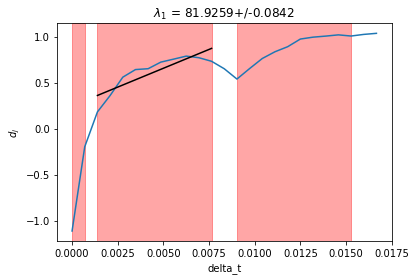

computed in  20.999040000000004 s
Expected time remaining =  673.6586396383929 s

225 ) Computing  Wed 20 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


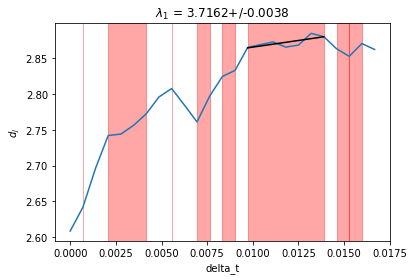

computed in  16.031912000000002 s
Expected time remaining =  649.5333180622223 s

226 ) Computing  Thu 21 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


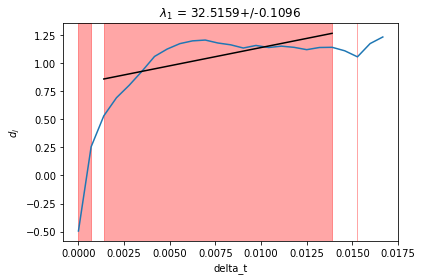

computed in  19.839930000000003 s
Expected time remaining =  625.9345597831859 s

227 ) Computing  Fri 22 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


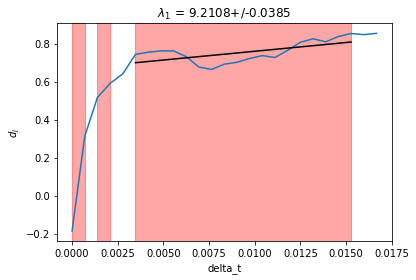

computed in  18.6593 s
Expected time remaining =  602.2336925903084 s

228 ) Computing  Mon 25 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


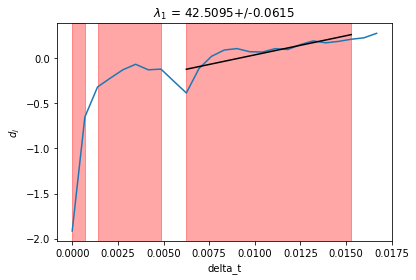

computed in  22.691346000000003 s
Expected time remaining =  579.0191599780702 s

229 ) Computing  Tue 26 Nov 2019 ... 

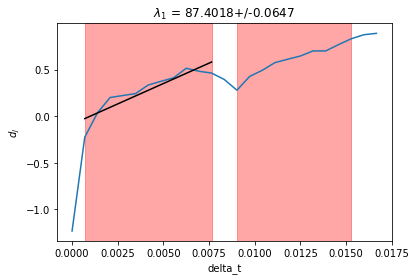

computed in  21.371095000000004 s
Expected time remaining =  555.6708297641921 s

230 ) Computing  Wed 27 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


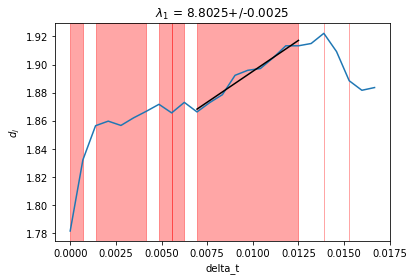

computed in  14.931429000000001 s
Expected time remaining =  531.6957263 s

231 ) Computing  Fri 29 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


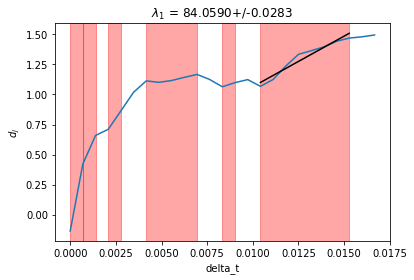

computed in  5.963428 s
Expected time remaining =  506.9448277142858 s

232 ) Computing  Mon 02 Dec 2019 ... 

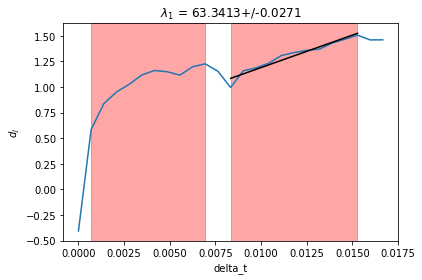

computed in  21.529261 s
Expected time remaining =  483.7648663448277 s

233 ) Computing  Tue 03 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


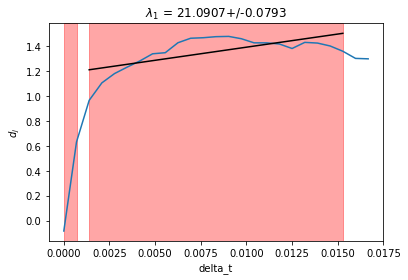

computed in  19.382008 s
Expected time remaining =  460.4147605150215 s

234 ) Computing  Wed 04 Dec 2019 ... 

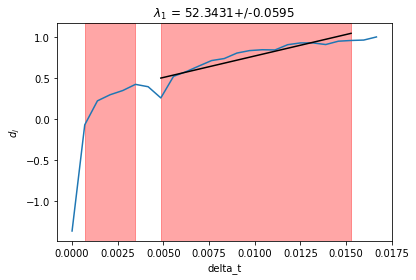

computed in  21.887207 s
Expected time remaining =  437.3019836452993 s

235 ) Computing  Thu 05 Dec 2019 ... 

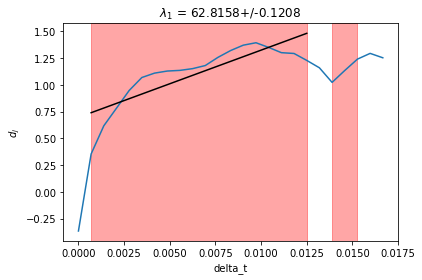

computed in  19.060731 s
Expected time remaining =  413.9831411234043 s

236 ) Computing  Fri 06 Dec 2019 ... 

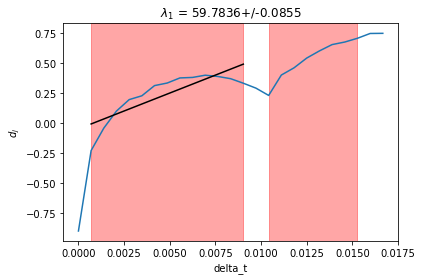

computed in  20.624928 s
Expected time remaining =  390.81305950000007 s

237 ) Computing  Mon 09 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


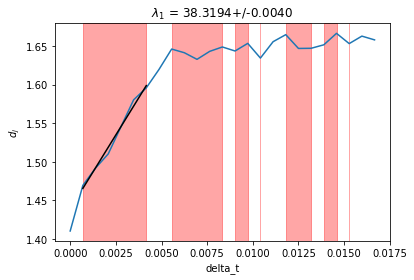

computed in  16.582041 s
Expected time remaining =  367.39151844725745 s

238 ) Computing  Tue 10 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


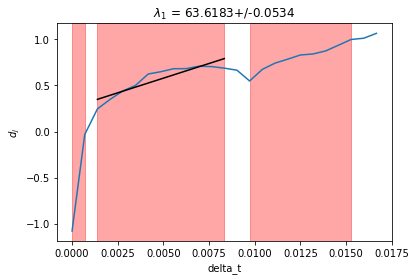

computed in  20.533858000000002 s
Expected time remaining =  344.2765162815126 s

239 ) Computing  Wed 11 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


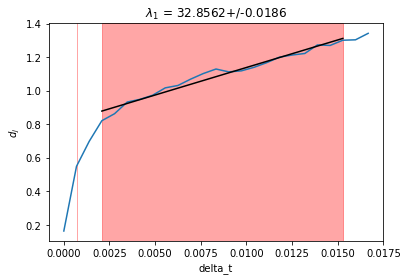

computed in  18.776476 s
Expected time remaining =  321.08017076987454 s

240 ) Computing  Thu 12 Dec 2019 ... 

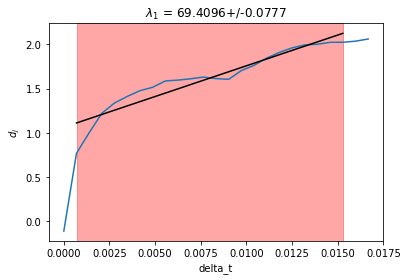

computed in  21.306876000000003 s
Expected time remaining =  298.05772083749997 s

241 ) Computing  Fri 13 Dec 2019 ... 

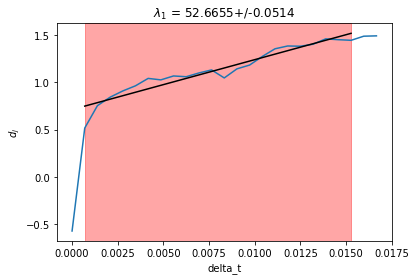

computed in  21.020728000000002 s
Expected time remaining =  275.03526 s

242 ) Computing  Mon 16 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


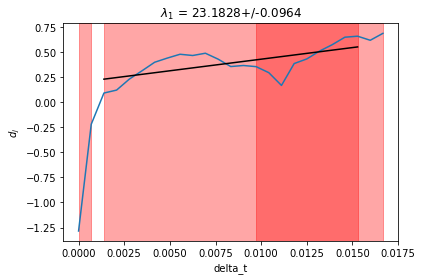

computed in  22.634533 s
Expected time remaining =  252.10269718181814 s

243 ) Computing  Tue 17 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


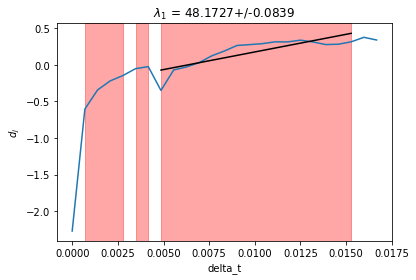

computed in  24.523675 s
Expected time remaining =  229.25032975308642 s

244 ) Computing  Wed 18 Dec 2019 ... 

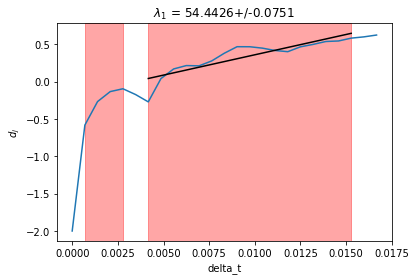

computed in  24.502838 s
Expected time remaining =  206.38349450409834 s

245 ) Computing  Thu 19 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


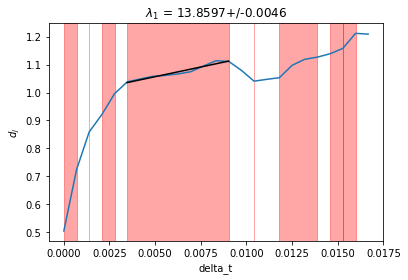

computed in  18.961541 s
Expected time remaining =  183.32236382040813 s

246 ) Computing  Fri 20 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


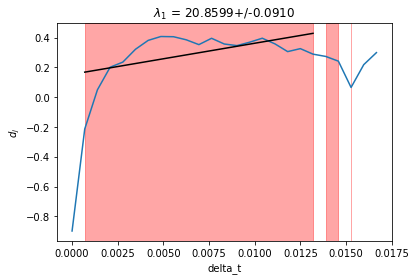

computed in  20.868276 s
Expected time remaining =  160.34881982113822 s

247 ) Computing  Mon 23 Dec 2019 ... 

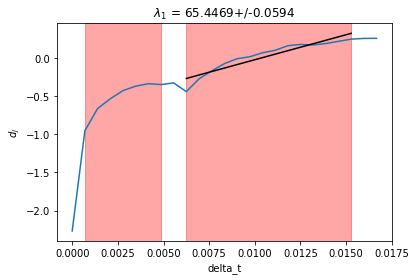

computed in  23.327858 s
Expected time remaining =  137.45206945748987 s

248 ) Computing  Tue 24 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


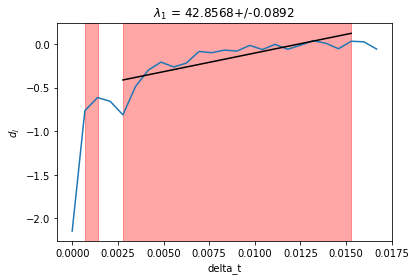

computed in  7.583043 s
Expected time remaining =  114.23440663306451 s

249 ) Computing  Thu 26 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


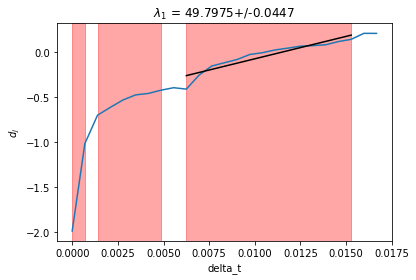

computed in  24.142312999999998 s
Expected time remaining =  91.40833545381525 s

250 ) Computing  Fri 27 Dec 2019 ... 

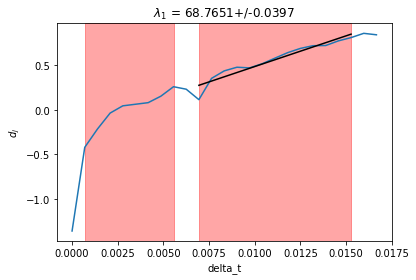

computed in  23.263989000000002 s
Expected time remaining =  68.56119445200001 s

251 ) Computing  Mon 30 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


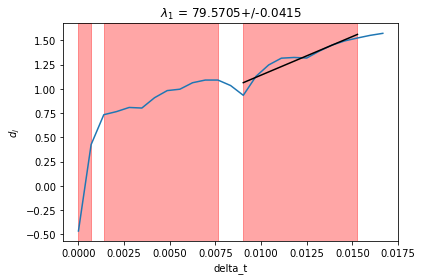

computed in  23.264796000000004 s
Expected time remaining =  45.710738382470126 s

252 ) Computing  Tue 31 Dec 2019 ... 

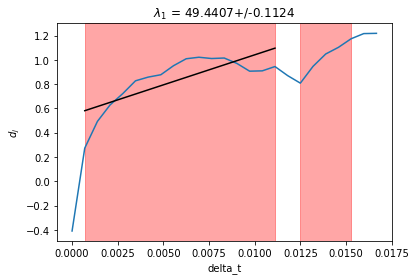

computed in  22.274638000000003 s
Expected time remaining =  22.85306470238096 s

253 ) Computing  Thu 02 Jan 2020 ... 

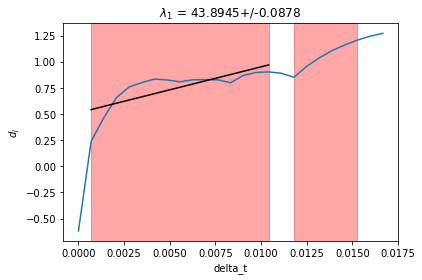

computed in  21.298146000000003 s
Expected time remaining =  0.0 s
computation time =  5780.957562


DATE  lyapunov_exponent     error
0   2019-01-02          29.541616  0.065346
1   2019-01-03          96.917937  0.100609
2   2019-01-04          40.116612  0.065491
3   2019-01-07          17.702593  0.024269
4   2019-01-08          21.563220  0.029538
5   2019-01-09          60.802334  0.067073
6   2019-01-10         -17.934946  0.011817
7   2019-01-11          34.558424  0.100414
8   2019-01-14          63.499396  0.026822
9   2019-01-15          54.400059  0.060249
10  2019-01-16          73.536868  0.063866
11  2019-01-17          35.238545  0.047281
12  2019-01-18          39.254799  0.031415
13  2019-01-22           7.329323  0.009054
14  2019-01-23          23.416060  0.016728
15  2019-01-24          50.029953  0.051878
16  2019-01-25          70.038087  0.049192
17  2019-01-28          77.289048  0.082404
18  2019-01-29          63.203568  0.072312
19  2019-01-30          13.225481  0.015465
20  2019-01-31          51.110145  0.078564
21  2019-02-01          43.146942  0.108465
22  2019-02-04          17.740378  0.014959
23  2019-02-05          31.043613  0.069966
24  2019-02-06          60.757001  0.041360
25  2019-02-07           9.723212  0.021978
26  2019-02-08          33.389080  0.052954
27  2019-02-11          45.837998  0.049491
28  2019-02-12          -5.692660  0.004125
29  2019-02-13          41.822045  0.016886
30  2019-02-14          13.384874  0.014686
31  2019-02-15          53.314372  0.069266
32  2019-02-19          14.434234  0.007003
33  2019-02-20          58.690179  0.053260
34  2019-02-21          14.413896  0.047036
35  2019-02-22          29.948424  0.027795
36  2019-02-25          57.876483  0.014092
37  2019-02-26          70.182697  0.044416
38  2019-02-27           5.081089  0.023427
39  2019-02-28          59.440774  0.027999
40  2019-03-01          38.460704  0.017418
41  2019-03-04          -6.081202  0.002035
42  2019-03-05          62.729499  0.071373
43  2019-03-06          21.970539  0.074887
44  2019-03-07          85.671573  0.036758
45  2019-03-08         114.538427  0.043342
46  2019-03-11         -13.371482  0.016539
47  2019-03-12          47.882763  0.127252
48  2019-03-13          -5.056632  0.009210
49  2019-03-14          49.785239  0.024685
50  2019-03-15          31.402280  0.006293
51  2019-03-18          45.786462  0.064845
52  2019-03-19          36.017977  0.069840
53  2019-03-20           7.219105  0.026172
54  2019-03-21          20.279561  0.013512
55  2019-03-22           4.437912  0.008817
56  2019-03-25          59.457283  0.058887
57  2019-03-26          12.617777  0.029262
58  2019-03-27          10.442512  0.009453
59  2019-03-28          -1.943392  0.032747
60  2019-03-29          62.993512  0.042258
61  2019-04-01          40.418386  0.064075
62  2019-04-02          70.544682  0.065715
63  2019-04-03          54.490226  0.019593
64  2019-04-04          50.533533  0.135861
65  2019-04-05          64.958187  0.084272
66  2019-04-08          21.468071  0.034516
67  2019-04-09          42.827075  0.095197
68  2019-04-10          65.314324  0.067800
69  2019-04-11          27.095437  0.047784
70  2019-04-12          68.293573  0.044467
71  2019-04-15          31.416702  0.119329
72  2019-04-16          43.581443  0.081884
73  2019-04-17          70.643615  0.055474
74  2019-04-18         -23.980603  0.011128
75  2019-04-22          84.554358  0.042711
76  2019-04-23         -21.443946  0.019073
77  2019-04-24          86.217293  0.036492
78  2019-04-25          40.382794  0.028810
79  2019-04-26          38.578223  0.035334
80  2019-04-29          27.203404  0.032916
81  2019-04-30          10.012064  0.015736
82  2019-05-01          98.781944  0.104458
83  2019-05-02          54.541188  0.006226
84  2019-05-03          19.214474  0.004506
85  2019-05-06          62.106841  0.065876
86  2019-05-07         -12.594197  0.016604
87  2019-05-08          66.682624  0.044309
88  2019-05-09          13.569216  0.006564
89  2019-05-10          33.818286  0.027403
90  20

In [39]:
calculate_lyapunov_exponents(SandP_1mins,start, end, plot_fit = True, plot_derivatives= False) 

Wed 11 Sep 2019 ... took 275 s?

# Compare to fractional data

In [46]:
results = pd.read_csv('2019-01-02 to 2020-01-02.csv')
results['DATE'] = pd.to_datetime(results['DATE'])

In [47]:
comparison = close_prices.loc[(close_prices['DATE'] >= start) & (close_prices['DATE'] <= end)]

In [57]:
plot_data = pd.merge(comparison, results)

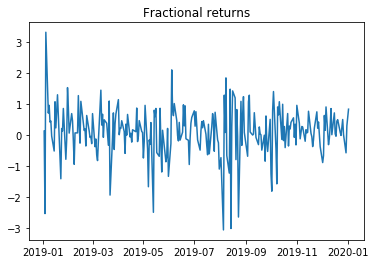

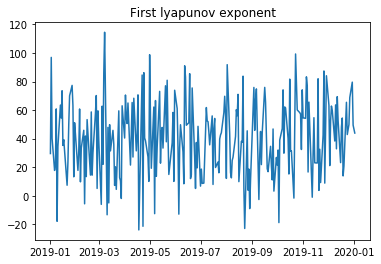

In [58]:
plt.plot( plot_data['DATE'],plot_data['Change %'], label = 'fractional change')
plt.title('Fractional returns')
plt.show();


plt.plot(plot_data['DATE'] ,plot_data['lyapunov_exponent'], label = 'lyapunov exponent')
plt.title('First lyapunov exponent')
plt.show();


gradient  -0.0036127607791854237
r squared  0.015102210012717054
gradient  0.549329591953255


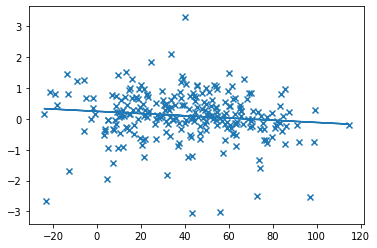

In [83]:
x = plot_data['lyapunov_exponent'].values.reshape(-1, 1)
y = plot_data['Change %'].values.reshape(-1, 1)
error = plot_data['error']
plt.scatter(x, y, marker = 'x')


regressor = LinearRegression() 
regressor.fit(x,y)
fit = regressor.predict(x) 

slope = regressor.coef_[0][0]
error = metrics.mean_absolute_error(y, fit)  
r_squared = metrics.r2_score(y,fit)

plt.plot(x,fit)

print("gradient ", slope)
print("r squared ", r_squared)
print("gradient ", error)

In [55]:
it_region_y = (x[start: end + 1]).values.reshape(-1,1)
    fit_region_x = (np.arange(start,end + 1) * delta_t).re
    
    regressor = LinearRegression() 
    regressor.fit(fit_region_x,fit_region_y)
    fit = regressor.predict(fit_region_x) 
    
    slope = regressor.coef_[0][0]
    error = metrics.mean_absolute_error(fit_region_y, fit)  
    r_squared = metrics.r2_score(fit_region_y,fit)

DATE     OPEN  Change %  lyapunov_exponent     error
0   2019-01-02  2509.98  0.123905          29.541616  0.065346
1   2019-01-03  2447.77 -2.541497          96.917937  0.100609
2   2019-01-04  2531.72  3.315928          40.116612  0.065491
3   2019-01-07  2549.69  0.704792          17.702593  0.024269
4   2019-01-08  2574.26  0.954449          21.563220  0.029538
5   2019-01-09  2584.97  0.414318          60.802334  0.067073
6   2019-01-10  2596.64  0.449427         -17.934946  0.011817
7   2019-01-11  2595.65 -0.038141          34.558424  0.100414
8   2019-01-14  2582.22 -0.520095          63.499396  0.026822
9   2019-01-15  2610.15  1.070053          54.400059  0.060249
10  2019-01-16  2616.10  0.227438          73.536868  0.063866
11  2019-01-17  2635.95  0.753049          35.238545  0.047281
12  2019-01-18  2670.57  1.296352          39.254799  0.031415
13  2019-01-22  2633.27 -1.416490           7.329323  0.009054
14  2019-01-23  2638.71  0.206161          23.416060  0.016728
15  2019-01-24  2642.01  0.124905          50.029953  0.051878
16  2019-01-25  2664.76  0.853735          70.038087  0.049192
17  2019-01-28  2643.93 -0.787842          77.289048  0.082404
18  2019-01-29  2639.93 -0.151519          63.203568  0.072312
19  2019-01-30  2680.87  1.527116          13.225481  0.015465
20  2019-01-31  2704.49  0.873362          51.110145  0.078564
21  2019-02-01  2706.08  0.058757          43.146942  0.108465
22  2019-02-04  2724.83  0.688116          17.740378  0.014959
23  2019-02-05  2737.21  0.452285          31.043613  0.069966
24  2019-02-06  2731.78 -0.198771          60.757001  0.041360
25  2019-02-07  2706.08 -0.949713           9.723212  0.021978
26  2019-02-08  2707.83  0.064627          33.389080  0.052954
27  2019-02-11  2709.60  0.065323          45.837998  0.049491
28  2019-02-12  2744.44  1.269476          -5.692660  0.004125
29  2019-02-13  2752.85  0.305502          41.822045  0.016886
30  2019-02-14  2745.56 -0.265520          13.384874  0.014686
31  2019-02-15  2775.66  1.084427          53.314372  0.069266
32  2019-02-19  2779.65  0.143543          14.434234  0.007003
33  2019-02-20  2785.06  0.194251          58.690179  0.053260
34  2019-02-21  2775.11 -0.358544          14.413896  0.047036
35  2019-02-22  2792.63  0.627366          29.948424  0.027795
36  2019-02-25  2796.14  0.125530          57.876483  0.014092
37  2019-02-26  2793.83 -0.082682          70.182697  0.044416
38  2019-02-27  2792.45 -0.049419           5.081089  0.023427
39  2019-02-28  2784.58 -0.282628          59.440774  0.027999
40  2019-03-01  2803.86  0.687623          38.460704  0.017418
41  2019-03-04  2793.21 -0.381282          -6.081202  0.002035
42  2019-03-05  2789.55 -0.131204          62.729499  0.071373
43  2019-03-06  2771.56 -0.649093          21.970539  0.074887
44  2019-03-07  2748.77 -0.829098          85.671573  0.036758
45  2019-03-08  2743.07 -0.207796         114.538427  0.043342
46  2019-03-11  2783.28  1.444698         -13.371482  0.016539
47  2019-03-12  2792.16  0.318033          47.882763  0.127252
48  2019-03-13  2810.92  0.667397          -5.056632  0.009210
49  2019-03-14  2808.71 -0.078684          49.785239  0.024685
50  2019-03-15  2822.48  0.487869          31.402280  0.006293
51  2019-03-18  2833.14  0.376261          45.786462  0.064845
52  2019-03-19  2833.55  0.014469          36.017977  0.069840
53  2019-03-20  2824.14 -0.333199           7.219105  0.026172
54  2019-03-21  2855.40  1.094768          20.279561  0.013512
55  2019-03-22  2800.95 -1.943983           4.437912  0.008817
56  2019-03-25  2798.51 -0.087189          59.457283  0.058887
57  2019-03-26  2818.54  0.710652          12.617777  0.029262
58  2019-03-27  2805.34 -0.470531          10.442512  0.009453
59  2019-03-28  2815.40  0.357320          -1.943392  0.032747
60  2019-03-29  2834.40  0.670336          62.993512  0.042258
61  2019-04-01  2867.06  1.139146          40.418386  0.064075
62  2019-04-02  2867.22  0.005580        

# Troubleshoot

In [31]:
dataframe = SandP_5mins.copy()
date = '2015-03-20'
column = "OPEN"
i_max = 5
plot = False
delta_t = 0.00347222222

regressor = LinearRegression()  

time_series = dataframe.loc[dataframe["DATE"] == date][column]

J = compute_lag(time_series, plot = False)
m = compute_embedding_dimension()
mu = compute_mean_period(time_series)



matrix = gen_phase_space_matrix(time_series, J, m)
matrix = matrix.dropna() ## drop rows that are missing a phase space co-ord (due to lag taking past end of list)

NN_pairs = []

for i in range(0,matrix.shape[0]):
    NN = find_nearest_neighbour(matrix, ref_index= i, mean_period = mu, i_max = i_max)
    NN_pairs.append([i,NN])

lyaponov_data = pd.DataFrame(compute_divergence(matrix, NN_pairs, i_max = i_max), columns = ['i','log(dj)'])

lyaponov_data['i_delta_t'] = lyaponov_data['i']*delta_t

y = lyaponov_data['log(dj)'].values.reshape(-1,1)
x = lyaponov_data['i_delta_t'].values.reshape(-1,1)

regressor.fit(x,y)

fit = regressor.predict(x) 

slope = regressor.coef_[0][0]
error = metrics.mean_absolute_error(y, fit)  
r_squared = metrics.r2_score(y,fit)

if (plot):

    print("Date = ", date)
    print("")
    print("lag J = ", J)
    print("embedding dimension m = ", m)
    print("period mu = ", mu)
    print("")
    print("Lyapunov exponent = ", slope, "+/-", error)
    print("R squared = ", r_squared)

    lyaponov_data.plot(x = 'i_delta_t', y = 'log(dj)')
    plt.plot (x, fit, c = 'k')
    plt.ylabel("log dj")
    plt.xlabel("i_delta_t")


lyaponov_data

i   log(dj)  i_delta_t
0  0  0.686843   0.000000
1  1  0.788167   0.003472
2  2  1.037661   0.006944
3  3  1.184572   0.010417
4  4  1.332528   0.013889

In [32]:
compute_divergence(matrix, NN_pairs, i_max = i_max)

[[0, 0.6868430731315429],
 [1, 0.7881672193449245],
 [2, 1.037661054967207],
 [3, 1.1845721374099427],
 [4, 1.3325283317978422]]

# Old calc lyapunov funct


def calc_daily_lyapunov_exponent(dataframe, date, column = "OPEN", i_max = 5, plot = False, delta_t_unit = 'days'):
    
    regressor = LinearRegression()  
    
    time_series = dataframe.loc[dataframe["DATE"] == date][column]
        
    J = compute_lag(time_series, plot = False)
    m = compute_embedding_dimension()
    mu = compute_mean_period(time_series)
    
    if delta_t_unit == 'mins':
        delta_t = 1
    elif delta_t_unit == 'hours':
        delta_t = 1/(60)
    elif delta_t_unit == 'days':
        delta_t = 1/(24*60)
    
    
    matrix = gen_phase_space_matrix(time_series, J, m)
    matrix = matrix.dropna() ## drop rows that are missing a phase space co-ord (due to lag taking past end of list)
        
    NN_pairs = []

    for i in range(0,matrix.shape[0]):
        NN = find_nearest_neighbour(matrix, ref_index= i, mean_period = mu, i_max = i_max)
        NN_pairs.append([i,NN])
        
    lyaponov_data = pd.DataFrame(compute_divergence(matrix, NN_pairs, i_max = i_max), columns = ['i','log(dj)'])
    
    lyaponov_data['i_delta_t'] = lyaponov_data['i']*delta_t
    
    y = lyaponov_data['log(dj)'].values.reshape(-1,1)
    x = lyaponov_data['i_delta_t'].values.reshape(-1,1)
    
    regressor.fit(x,y)
    
    fit = regressor.predict(x) 
    
    slope = regressor.coef_[0][0]
    error = metrics.mean_absolute_error(y, fit)  
    r_squared = metrics.r2_score(y,fit)
                            
    if (plot):
        
        print("Date = ", date)
        print("")
        print("lag J = ", J)
        print("embedding dimension m = ", m)
        print("period mu = ", mu)
        print("")
        print("Lyapunov exponent = ", slope, "+/-", error)
        print("R squared = ", r_squared)
        
        lyaponov_data.plot(x = 'i_delta_t', y = 'log(dj)')
        plt.plot (x, fit, c = 'k')
        plt.ylabel("log dj")
        plt.xlabel("i_delta_t")
        
        plt.show()

    
    return lyaponov_data, slope, r_squared